In [ ]:
!pip install opendatasets --quiet

import opendatasets as od

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# **Data Preparation**

## Dataset I
Our baseline dataset is [2023 Africa Cup of Nations with ML](https://www.kaggle.com/code/oussamalariouch/2023-africa-cup-of-nations-with-ml)

In [ ]:
od.download('https://www.kaggle.com/datasets/oussamalariouch/african-national-football-from-2010-2024')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jd
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/oussamalariouch/african-national-football-from-2010-2024


100%|██████████| 66.4k/66.4k [00:00<00:00, 153MB/s]

In [ ]:
af_df = pd.read_csv('African-Nations-results.csv')
af_df.sample(5)

## Dataset II
Our baseline dataset luck recent result of AFCON 2024, therefore I've look and find another dataset that contains the result of last AFCON found in [statsbomb open datasets](https://github.com/statsbomb/open-data)

The data is in a json format. Hence, a proper data mapping to pandas df should be done

In [ ]:
import json

def matches_from_json(json_path: str, fmt="dataframe"):
    """
    Load matches from a local JSON file and return raw data or a DataFrame.
    """

    # Load JSON file
    with open(json_path, "r", encoding="utf-8") as f:
        matches = json.load(f)

    if fmt != "dataframe":
        return matches

    # Extract managers
    home_managers = [
        ", ".join(m["name"] for m in match.get("home_team", {}).get("managers", []))
        for match in matches
    ]

    away_managers = [
        ", ".join(m["name"] for m in match.get("away_team", {}).get("managers", []))
        for match in matches
    ]

    # Create DataFrame
    df = pd.DataFrame(matches)

    # Competition: "Country - Competition"
    df["competition"] = df["competition"].apply(
        lambda c: f"{c['country_name']} - {c['competition_name']}"
    )

    # Flatten main name fields
    for col in ["season", "home_team", "away_team"]:
        df[col] = df[col].apply(lambda c: c[f"{col}_name"])

    # Optional nested objects
    for col in ["competition_stage", "stadium", "referee"]:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda x: x["name"] if isinstance(x, dict) else x
            )

    # Add managers
    df["home_managers"] = home_managers
    df["away_managers"] = away_managers

    # Extract metadata fields
    metadata = df.pop("metadata")
    for k in ["data_version", "shot_fidelity_version", "xy_fidelity_version"]:
        df[k] = metadata.apply(lambda x: x.get(k) if isinstance(x, dict) else None)

    return df


In [ ]:
df = matches_from_json("./Data/107.json")
df.head()

In [ ]:
df.columns

Now after read our dataset we need to transform it to the same structure of our baseline dataset

In [ ]:
def matches_from_json_mapped(json_path: str):
    with open(json_path, "r", encoding="utf-8") as f:
        matches = json.load(f)

    df = pd.DataFrame(matches)

    mapped_df = pd.DataFrame({
        "date": df["match_date"],
        "home_team": df["home_team"].apply(lambda x: x["home_team_name"]),
        "away_team": df["away_team"].apply(lambda x: x["away_team_name"]),
        "home_score": df["home_score"],
        "away_score": df["away_score"],
        "tournament": df["competition"].apply(
            lambda x: x["competition_name"]
        )
    })

    return mapped_df

In [ ]:
sx = matches_from_json_mapped('../../Downloads/107.json')

In [ ]:
sx[(sx['home_team'] == 'Morocco') | (sx['away_team'] == 'Morocco')]

,date,home_team,away_team,home_score,away_score,tournament
12,2024-01-30,Morocco,South Africa,0,2,African Cup of Nations
20,2024-01-24,Zambia,Morocco,0,1,African Cup of Nations
34,2024-01-21,Morocco,Congo DR,1,1,African Cup of Nations
44,2024-01-17,Morocco,Tanzania,3,0,African Cup of Nations


## Datasets Concatenation

In [ ]:
afcon_all_df = pd.concat([af_df, sx])

In [ ]:
afcon_all_df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament
7971,3/27/2022,Liberia,Sierra Leone,0,1,Friendly
4590,10/6/2016,Kosovo,Croatia,0,6,FIFA World Cup qualification
5477,11/13/2017,Armenia,Cyprus,3,2,Friendly
3586,4/15/2015,United States,Mexico,2,0,Friendly
2030,11/29/2012,Rwanda,Zanzibar,1,2,CECAFA Cup


Now, I've choose to keep only the games related to the CUP

In [ ]:
afcon_all_df = afcon_all_df[afcon_all_df['tournament']=='African Cup of Nations']

In [ ]:
pd.concat([afcon_all_df['home_team'], afcon_all_df['away_team']]).unique()

array(['Angola', 'Ivory Coast', 'Malawi', 'Egypt', 'Mozambique',
       'Cameroon', 'Zambia', 'Mali', 'Nigeria', 'Gabon', 'Burkina Faso',
       'Algeria', 'Ghana', 'Equatorial Guinea', 'Senegal', 'Morocco',
       'Libya', 'Sudan', 'Niger', 'Botswana', 'South Africa', 'Tunisia',
       'Cape Verde', 'DR Congo', 'Ethiopia', 'Togo', 'Congo', 'Guinea',
       'Guinea-Bissau', 'Zimbabwe', 'Uganda', 'Madagascar', 'Kenya',
       'Mauritania', 'Benin', 'Burundi', 'Tanzania', 'Namibia', 'Comoros',
       'Gambia', 'Sierra Leone', "Côte d'Ivoire", 'Cape Verde Islands',
       'Congo DR'], dtype=object)

## Country abbreviations

Now, I will transform the name of each country to its FIFA abbrv to faciliate our data scraping as well as normalizing the text

In [ ]:
!pip install country_converter --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
import country_converter as coco

cc = coco.CountryConverter()

afcon_all_df['home_abrv'] = afcon_all_df['home_team'].apply(
    lambda x: cc.convert(names=x, to='FIFA')
)

afcon_all_df['away_abrv'] = afcon_all_df['away_team'].apply(
    lambda x: cc.convert(names=x, to='FIFA')
)

afcon_all_df['home_abrv'] = afcon_all_df['home_abrv'].replace(
    {
        'SUD': 'SDN',
        'EDQ': 'EQG'
    }
)

afcon_all_df['away_abrv'] = afcon_all_df['away_abrv'].replace(
    {
        'SUD': 'SDN',
        'EDQ': 'EQG'
    }
)

In [ ]:
afcon_all_df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,home_abrv,away_abrv
1315,1/22/2012,Ivory Coast,Sudan,1,0,African Cup of Nations,CIV,SDN
6327,6/25/2019,Ghana,Benin,2,2,African Cup of Nations,GHA,BEN
6333,6/27/2019,Kenya,Tanzania,3,2,African Cup of Nations,KEN,TAN
35,2024-01-20,Tunisia,Mali,1,1,African Cup of Nations,TUN,MLI
7806,1/19/2022,Egypt,Sudan,1,0,African Cup of Nations,EGY,SDN


In [ ]:
all_country_codes = pd.concat([afcon_all_df['home_abrv'], afcon_all_df['away_abrv']]).unique()

In [ ]:
all_country_codes

array(['ANG', 'CIV', 'MWI', 'EGY', 'MOZ', 'CMR', 'ZAM', 'MLI', 'NGA',
       'GAB', 'BFA', 'ALG', 'GHA', 'EQG', 'SEN', 'MAR', 'LBY', 'SDN',
       'NIG', 'BOT', 'RSA', 'TUN', 'CPV', 'COD', 'ETH', 'TOG', 'CGO',
       'GUI', 'GNB', 'ZIM', 'UGA', 'MAD', 'KEN', 'MTN', 'BEN', 'BDI',
       'TAN', 'NAM', 'COM', 'GAM', 'SLE'], dtype=object)

## FIFA Country Rank

### Fetching the Data

Creating a coulmn that represent the country rank is a crucial metric to measure the developement and the power of the team, because in football often the high ranked team won unless there is some exceptions. Therefore to do so I've fetch the `inside fifa api` which is not publicly annouced but I've figureout a way to get it 😂😂😂.

In [ ]:
import requests

BASE_URL = "https://inside.fifa.com/api/rankings/by-country"
START_YEAR = 2010
END_YEAR = 2025
HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

def fetch_country_rankings(country_code):
    """Fetch raw ranking history for one country"""
    params = {
        "gender": 1,
        "countryCode": country_code,
        "locale": "en"
    }
    r = requests.get(BASE_URL, params=params, headers=HEADERS, timeout=10)
    r.raise_for_status()
    return r.json()["rankings"]

In [ ]:
def extract_final_rank_per_year(rankings, country_code):
    """Keep final (latest) rank for each year"""
    rows = []

    # Convert to DataFrame for easier handling
    df = pd.DataFrame(rankings)

    # Extract country name from JSON
    country_name = rankings[0]["TeamName"][0]["Description"]

    # Extract year from publication date
    df["year"] = pd.to_datetime(df["PubDate"]).dt.year

    # Keep only target years
    df = df[(df["year"] >= START_YEAR) & (df["year"] <= END_YEAR)]

    # Sort so latest ranking in the year is last
    df = df.sort_values("PubDate")

    # Keep last rank per year
    final_per_year = df.groupby("year").tail(1)

    for _, row in final_per_year.iterrows():
        rows.append({
            "country": country_name,
            "country_code": country_code,
            "year": int(row["year"]),
            "rank": int(row["Rank"])
        })

    return rows

In [ ]:
import time

def build_rankings_dataframe(countries):
    all_rows = []

    for code in countries:
        print(f"Fetching {code}...")
        time.sleep(5)
        rankings = fetch_country_rankings(code)
        rows = extract_final_rank_per_year(rankings, code)
        all_rows.extend(rows)

    return pd.DataFrame(all_rows).sort_values(["country", "year"])

In [ ]:
rankings_df = build_rankings_dataframe(all_country_codes)

Fetching ANG...
Fetching CIV...
Fetching MWI...
Fetching EGY...
Fetching MOZ...
Fetching CMR...
Fetching ZAM...
Fetching MLI...
Fetching NGA...
Fetching GAB...
Fetching BFA...
Fetching ALG...
Fetching GHA...
Fetching EQG...
Fetching SEN...
Fetching MAR...
Fetching LBY...
Fetching SDN...
Fetching NIG...
Fetching BOT...
Fetching RSA...
Fetching TUN...
Fetching CPV...
Fetching COD...
Fetching ETH...
Fetching TOG...
Fetching CGO...
Fetching GUI...
Fetching GNB...
Fetching ZIM...
Fetching UGA...
Fetching MAD...
Fetching KEN...
Fetching MTN...
Fetching BEN...
Fetching BDI...
Fetching TAN...
Fetching NAM...
Fetching COM...
Fetching GAM...
Fetching SLE...


after fetching the api and creating a pandas df, here is a view of our dataset.

In [ ]:
rankings_df.head()

,country,country_code,year,rank
176,Algeria,ALG,2010,35
177,Algeria,ALG,2011,30
178,Algeria,ALG,2012,19
179,Algeria,ALG,2013,26
180,Algeria,ALG,2014,18


save the dataset to don't fetch overload the server by fetching it each time I run the notebook

In [ ]:
rankings_df.to_csv('afcon_team_rank-2010_2025.csv')

## Rank

Now, when the ranks is in our hands I will create two columns that represent the home and away ranks.

In [ ]:
afcon_all_df['year'] = pd.to_datetime(afcon_all_df['date'], format='mixed').dt.year
afcon_all_df['month'] = pd.to_datetime(afcon_all_df['date'], format='mixed').dt.month
afcon_all_df['day'] = pd.to_datetime(afcon_all_df['date'], format='mixed').dt.day

In [ ]:
def get_rank(row, team_abrv_col):
    country_code = row[team_abrv_col]
    year = row['year']
    matching_ranks = rankings_df[(rankings_df['country_code'] == country_code) & (rankings_df['year'] == year)]['rank']
    if not matching_ranks.empty:
        return matching_ranks.iloc[0]
    return None

afcon_all_df['home_rank'] = afcon_all_df.apply(lambda row: get_rank(row, 'home_abrv'), axis=1)
afcon_all_df['away_rank'] = afcon_all_df.apply(lambda row: get_rank(row, 'away_abrv'), axis=1)

here is a view of our dataset with these two new columns

In [ ]:
afcon_all_df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,home_abrv,away_abrv,year,month,day,home_rank,away_rank
24,2024-01-23,Mauritania,Algeria,1,0,African Cup of Nations,MTN,ALG,2024,1,23,109,37
47,1/28/2010,Ghana,Nigeria,1,0,African Cup of Nations,GHA,NGA,2010,1,28,16,32
4850,2/5/2017,Egypt,Cameroon,1,2,African Cup of Nations,EGY,CMR,2017,2,5,31,45
4821,1/17/2017,Mali,Egypt,0,0,African Cup of Nations,MLI,EGY,2017,1,17,72,31
2,2024-02-07,Côte d'Ivoire,Congo DR,1,0,African Cup of Nations,CIV,COD,2024,2,7,46,61


## AFCON Winner Record

To have a rich dataset I've thaught of adding the AFCON winner record of alltime

In [ ]:
afcon_winners_record = {
    "EGY": 7,
    "CMR": 5,
    "GHA": 4,
    "CIV": 3,
    "NGA": 3,
    "ALG": 2,
    "COD": 2,
    "SEN": 1,
    "ZAM": 1,
    "TUN": 1,
    "RSA": 1,
    "MAR": 1,
    "ZRE": 1,
    "CGO": 1,
    "SDN": 1,
    "ETH": 1
}
afcon_all_df['home_cup_win_record'] = afcon_all_df['home_abrv'].apply(lambda x: afcon_winners_record.get(x,0))
afcon_all_df['away_cup_win_record'] = afcon_all_df['away_abrv'].apply(lambda x: afcon_winners_record.get(x,0))

In [ ]:
afcon_all_df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,home_abrv,away_abrv,year,month,day,home_rank,away_rank,home_cup_win_record,away_cup_win_record
3467,1/23/2015,Ghana,Algeria,1,0,African Cup of Nations,GHA,ALG,2015,1,23,33,28,4,2
7819,1/24/2022,Guinea,Gambia,0,1,African Cup of Nations,GUI,GAM,2022,1,24,83,126,0,0
3458,1/19/2015,Algeria,South Africa,3,1,African Cup of Nations,ALG,RSA,2015,1,19,28,72,2,1
6360,7/10/2019,Nigeria,South Africa,2,1,African Cup of Nations,NGA,RSA,2019,7,10,31,71,3,1
4829,1/21/2017,Ghana,Mali,1,0,African Cup of Nations,GHA,MLI,2017,1,21,50,72,4,0


## AFCON Hosting History

To have a rich dataset I've thaught of adding the AFCON hosting history of all time, because team that is hosting the tournament has an adventage of fan and stadium

In [ ]:
afcon_hosting_history = {
    2010: ["ANG"],
    2012: ["GAB", "EQG"],  # co-hosted
    2013: ["RSA"],
    2015: ["EQG"],
    2017: ["GAB"],
    2019: ["EGY"],
    2022: ["CMR"],
    2024: ["CIV"],
}


afcon_all_df['is_home_hosting'] = afcon_all_df.apply(
    lambda row: 1 if row['year'] in afcon_hosting_history and row['home_abrv'] in afcon_hosting_history[row['year']] else 0,
    axis=1
)

afcon_all_df['is_away_hosting'] = afcon_all_df.apply(
    lambda row: 1 if row['year'] in afcon_hosting_history and row['away_abrv'] in afcon_hosting_history[row['year']] else 0,
    axis=1
)

In [ ]:
afcon_all_df['hosted_country'] = afcon_all_df['year'].map(lambda x: afcon_hosting_history.get(x)[0])

In [ ]:
afcon_all_df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,home_abrv,away_abrv,year,month,day,home_cup_win_record,away_cup_win_record,is_home_hosting,is_away_hosting,hosted_country
3462,1/21/2015,Equatorial Guinea,Burkina Faso,0,0,African Cup of Nations,EQG,BFA,2015,1,21,0,0,1,0,EQG
6321,6/23/2019,Algeria,Kenya,2,0,African Cup of Nations,ALG,KEN,2019,6,23,2,0,0,0,EGY
2105,1/24/2013,Niger,DR Congo,0,0,African Cup of Nations,NIG,COD,2013,1,24,0,2,0,0,RSA
3460,1/20/2015,Ivory Coast,Guinea,1,1,African Cup of Nations,CIV,GUI,2015,1,20,3,0,0,0,EQG
4831,1/22/2017,Gabon,Cameroon,0,0,African Cup of Nations,GAB,CMR,2017,1,22,0,5,1,0,GAB


## Weather Condition

I think every football fan knows how much the weather condition is hard and how they affluence the performance of teams especialy for countries that have more player playing in european league then the national league, because the last player are used to these condition and can perform better in mama africa weather condition. Therefore I've use a public weather api that provide current and historical data here is the [`API`](https://archive-api.open-meteo.com/v1/archive)

### Define Latitude and Longtitude

Now let's define latitude and longtitude of each hosted capital city

In [ ]:
HOST_CAPITAL_COORDS = {
    "ANG": {  # Angola
        "country": "Angola",
        "capital": "Luanda",
        "lat": -8.8390,
        "lon": 13.2894
    },
    "GAB": {  # Gabon
        "country": "Gabon",
        "capital": "Libreville",
        "lat": 0.4162,
        "lon": 9.4673
    },
    "EQG": {  # Equatorial Guinea
        "country": "Equatorial Guinea",
        "capital": "Malabo",
        "lat": 3.7500,
        "lon": 8.7833
    },
    "RSA": {  # South Africa
        "country": "South Africa",
        "capital": "Pretoria",
        "lat": -25.7479,
        "lon": 28.2293
    },
    "EGY": {  # Egypt
        "country": "Egypt",
        "capital": "Cairo",
        "lat": 30.0444,
        "lon": 31.2357
    },
    "CMR": {  # Cameroon
        "country": "Cameroon",
        "capital": "Yaoundé",
        "lat": 3.8480,
        "lon": 11.5021
    },
    "CIV": {  # Ivory Coast
        "country": "Ivory Coast",
        "capital": "Yamoussoukro",
        "lat": 6.8276,
        "lon": -5.2893
    },
    "MAR":{
        "country": "Morocco",
        "capital": "Rabat",
        "lat": 34.0209,
        "lon": -6.8416},
}

### API Fetching

In [ ]:
def get_monthly_weather_avg(lat, lon, year, month, day=1):
    year = int(year)
    month = int(month)
    # day = int(day)
    # start_date = f"{year}-{month:02d}-{day}"
    # end_date   = f"{year}-{month:02d}-{day}"
    start_date = f"{year}-{month:02d}-01"
    end_date   = f"{year}-{month:02d}-28"


    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_mean,relative_humidity_2m_mean",
        "timezone": "UTC"
    }

    r = requests.get(url, params=params).json()
    # print(r)
    if "daily" not in r:
        return {"avg_temp": None, "avg_humidity": None}
    df = pd.DataFrame(r["daily"])

    return {
        "avg_temp": df["temperature_2m_mean"].mean(),
        "avg_humidity": df["relative_humidity_2m_mean"].mean()
    }

In [ ]:
def get_afcon_host_weather(host_country, year, month, day=None):
    capital = HOST_CAPITAL_COORDS[host_country]
    weather = get_monthly_weather_avg(
        capital["lat"],
        capital["lon"],
        year,
        month,
        day
    )

    return {
        "host_country": host_country,
        "capital": capital["capital"],
        "avg_temp_host": weather["avg_temp"],
        "avg_humidity_host": weather["avg_humidity"]
    }

Testing wether our fetching and transformation is working

In [ ]:
get_afcon_host_weather('MAR', year=2023, month=12, day=18)

{'host_country': 'MAR',
 'capital': 'Rabat',
 'avg_temp_host': np.float64(14.607142857142856),
 'avg_humidity_host': np.float64(76.92857142857143)}

In [ ]:
to_get_hosts_weather = afcon_all_df.groupby(['hosted_country', 'year', 'month']).size().reset_index(name='count')

In [ ]:
to_get_hosts_weather.head()

,hosted_country,year,month,count
0,ANG,2010,1,29
1,CIV,2024,1,44
2,CIV,2024,2,8
3,CMR,2022,1,48
4,CMR,2022,2,4


In [ ]:
weather_data = to_get_hosts_weather.apply(
    lambda row: get_afcon_host_weather(
        row["hosted_country"],
        row["year"],
        row["month"],
    ),
    axis=1
)

to_get_hosts_weather["avg_temp_host"] = weather_data.apply(lambda x: x['avg_temp_host'])
to_get_hosts_weather["avg_humidity_host"] = weather_data.apply(lambda x: x['avg_humidity_host'])

Here is a view:

In [ ]:
to_get_hosts_weather.sample(5)

,hosted_country,year,month,count,avg_temp_host,avg_humidity_host
2,CIV,2024,2,8,28.557143,58.892857
9,GAB,2012,1,22,25.382143,87.607143
7,EQG,2015,1,26,26.785714,83.357143
11,GAB,2017,1,28,26.078571,87.750000
8,EQG,2015,2,6,27.357143,85.357143


### Weather condition Columns

In [ ]:
afcon_all_df = pd.merge(afcon_all_df, to_get_hosts_weather, on=['hosted_country', 'year', 'month'], how='inner')

In [ ]:
afcon_all_df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,home_abrv,away_abrv,year,month,...,away_rank,home_cup_win_record,away_cup_win_record,is_home_hosting,is_away_hosting,hosted_country,weather_key,count,avg_temp_host,avg_humidity_host
263,2024-02-07,Côte d'Ivoire,Congo DR,1,0,African Cup of Nations,CIV,COD,2024,2,...,61,3,2,1,0,CIV,CIV_2024_2,8,28.557143,58.892857
202,7/10/2019,Senegal,Benin,1,0,African Cup of Nations,SEN,BEN,2019,7,...,84,1,0,0,0,EGY,EGY_2019_7,24,31.010714,44.107143
59,2/11/2012,Ghana,Mali,0,2,African Cup of Nations,GHA,MLI,2012,2,...,25,4,0,0,0,GAB,GAB_2012_2,10,25.539286,88.107143
253,1/29/2022,Burkina Faso,Tunisia,1,0,African Cup of Nations,BFA,TUN,2022,1,...,30,0,1,0,0,CMR,CMR_2022_1,48,24.435714,70.857143
243,1/20/2022,Gambia,Tunisia,1,0,African Cup of Nations,GAM,TUN,2022,1,...,30,0,1,0,0,CMR,CMR_2022_1,48,24.435714,70.857143


In [ ]:
afcon_all_df.to_csv('afcon_full_dataset_v1.csv', index=False)

In [ ]:
afcon_all_df = pd.read_csv('./Data/afcon_full_dataset_v1.csv')

## TransferMarket Scraping

TransferMarket is one of the bigest source of statistics when it comes to football, therefore adding thse statistics to our dataset will make it reacher. Therefore I am going to get the data for each team in each tournament.

In [ ]:
!pip install beautifulsoup4 --quiet

In [ ]:
import re
import time
from bs4 import BeautifulSoup

Tranfermarket use team ids to retrieve the information, therefore we need to find these ids

### Team IDs

In [ ]:
def get_team_id(country_name):
    # Prepare the search URL
    search_url = f"https://www.transfermarkt.com/schnellsuche/ergebnis/schnellsuche?query={country_name}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Get the search page
    response = requests.get(search_url, headers=headers)
    if response.status_code != 200:
        print("Error fetching the page")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    # Look for links to national team squads
    links = soup.find_all("a", href=True)
    for link in links:
        href = link['href']
        # Pattern for national team squad page
        match = re.search(r'/kader/verein/(\d+)', href)
        if match:
            team_id = match.group(1)
            print(f"Found team ID for {country_name}: {team_id}")
            return team_id

    print(f"Team ID for {country_name} not found")
    return None

In [ ]:
countries_name = pd.concat([afcon_all_df['home_team'], afcon_all_df['away_team']]).unique()

In [ ]:
countries_id_name_transfermarket = {}

for country_name in countries_name:
    countries_id_name_transfermarket[country_name] = get_team_id(country_name)
    time.sleep(2)

Found team ID for Angola: 3585
Found team ID for Ivory Coast: 3591
Found team ID for Malawi: 8988
Found team ID for Egypt: 3672
Found team ID for Mozambique: 5129
Found team ID for Cameroon: 3434
Found team ID for Zambia: 3703
Found team ID for Mali: 3674
Found team ID for Nigeria: 3444
Found team ID for Gabon: 5704
Found team ID for Burkina Faso: 5872
Found team ID for Algeria: 3614
Found team ID for Ghana: 3441
Found team ID for Equatorial Guinea: 13485
Found team ID for Senegal: 3499
Found team ID for Morocco: 3575
Found team ID for Libya: 6602
Found team ID for Sudan: 13313
Found team ID for Niger: 3444
Found team ID for Botswana: 15229
Found team ID for South Africa: 3806
Found team ID for Tunisia: 3670
Found team ID for Cape Verde: 4311
Found team ID for DR Congo: 3854
Found team ID for Ethiopia: 13941
Found team ID for Togo: 3815
Found team ID for Congo: 3854
Found team ID for Guinea: 3856
Found team ID for Guinea-Bissau: 3701
Found team ID for Zimbabwe: 3583
Found team ID for U

In [ ]:
countries_id_name_transfermarket['Cape Verde Islands'] = 4311
countries_id_name_transfermarket['Congo DR'] = 3854

here is a view of our dict of `{country: team_id}`

In [ ]:
countries_id_name_transfermarket

{'Angola': '3585',
 'Ivory Coast': '3591',
 'Malawi': '8988',
 'Egypt': '3672',
 'Mozambique': '5129',
 'Cameroon': '3434',
 'Zambia': '3703',
 'Mali': '3674',
 'Nigeria': '3444',
 'Gabon': '5704',
 'Burkina Faso': '5872',
 'Algeria': '3614',
 'Ghana': '3441',
 'Equatorial Guinea': '13485',
 'Senegal': '3499',
 'Morocco': '3575',
 'Libya': '6602',
 'Sudan': '13313',
 'Niger': '3444',
 'Botswana': '15229',
 'South Africa': '3806',
 'Tunisia': '3670',
 'Cape Verde': '4311',
 'DR Congo': '3854',
 'Ethiopia': '13941',
 'Togo': '3815',
 'Congo': '3854',
 'Guinea': '3856',
 'Guinea-Bissau': '3701',
 'Zimbabwe': '3583',
 'Uganda': '13497',
 'Madagascar': '14635',
 'Kenya': '8987',
 'Mauritania': '14238',
 'Benin': '3955',
 'Burundi': '13943',
 'Tanzania': '14666',
 'Namibia': '3573',
 'Comoros': '16430',
 'Gambia': '6186',
 'Sierra Leone': '6187',
 "Côte d'Ivoire": '3591',
 'Cape Verde Islands': 4311,
 'Congo DR': 3854}

create another one with countries abbreviations based on the previous dict

In [ ]:
countries_id_name_transfermarket_abrv = {}
for country, team_id in countries_id_name_transfermarket.items():
    countries_id_name_transfermarket_abrv[cc.convert(names=country, to='FIFA')] = team_id

countries_id_name_transfermarket_abrv['SDN'] = countries_id_name_transfermarket_abrv.pop('SUD')
countries_id_name_transfermarket_abrv['EQG'] = countries_id_name_transfermarket_abrv.pop('EDQ')

In [ ]:
countries_id_name_transfermarket_abrv

{'ANG': '3585',
 'CIV': '3591',
 'MWI': '8988',
 'EGY': '3672',
 'MOZ': '5129',
 'CMR': '3434',
 'ZAM': '3703',
 'MLI': '3674',
 'NGA': '3444',
 'GAB': '5704',
 'BFA': '5872',
 'ALG': '3614',
 'GHA': '3441',
 'SEN': '3499',
 'MAR': '3575',
 'LBY': '6602',
 'NIG': '3444',
 'BOT': '15229',
 'RSA': '3806',
 'TUN': '3670',
 'CPV': 4311,
 'COD': 3854,
 'ETH': '13941',
 'TOG': '3815',
 'CGO': '3854',
 'GUI': '3856',
 'GNB': '3701',
 'ZIM': '3583',
 'UGA': '13497',
 'MAD': '14635',
 'KEN': '8987',
 'MTN': '14238',
 'BEN': '3955',
 'BDI': '13943',
 'TAN': '14666',
 'NAM': '3573',
 'COM': '16430',
 'GAM': '6186',
 'SLE': '6187',
 'SDN': '13313',
 'EQG': '13485'}

add the team id to our intial dataset

In [ ]:
afcon_all_df['home_id'] = afcon_all_df['home_abrv'].apply(lambda x: countries_id_name_transfermarket_abrv.get(x))
afcon_all_df['away_id'] = afcon_all_df['away_abrv'].map(lambda x: countries_id_name_transfermarket_abrv.get(x))

In [ ]:
afcon_all_df.sample(3)

,date,home_team,away_team,home_score,away_score,tournament,home_abrv,away_abrv,year,month,...,away_cup_win_record,is_home_hosting,is_away_hosting,hosted_country,weather_key,count,avg_temp_host,avg_humidity_host,home_id,away_id
114,1/27/2015,South Africa,Ghana,1,2,African Cup of Nations,RSA,GHA,2015,1,...,4,0,0,EQG,EQG_2015_1,26,26.785714,83.357143,3806,3441
242,1/20/2022,Sierra Leone,Equatorial Guinea,0,1,African Cup of Nations,SLE,EQG,2022,1,...,0,0,0,CMR,CMR_2022_1,48,24.435714,70.857143,6187,13485
256,1/30/2022,Senegal,Equatorial Guinea,3,1,African Cup of Nations,SEN,EQG,2022,1,...,0,0,0,CMR,CMR_2022_1,48,24.435714,70.857143,3499,13485


### Team Stats (AVG Age, Attack, Mid; Def value)

In [ ]:
years = afcon_all_df['year'].unique()
print(years)

[2010 2012 2013 2015 2017 2019 2022 2024]


In [ ]:
def get_team_stats(team_id, year):
    url = f'https://www.transfermarkt.com/morocco/kader/verein/{int(team_id)}/plus/0/galerie/0?saison_id={int(year)}'
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print(f"Failed to fetch team {team_id} for year {year}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')
    try:
        table = soup.find_all('div', class_="box")[1].find('table')
    except IndexError:
        print(f"No table found for team {team_id} in year {year}")
        return None

    data_dict = {'team_id': team_id, 'year': year}

    # Extract players info
    for row in table.find('tbody').find_all('tr'):
        cols = row.find_all('td')
        if len(cols) < 5:
            continue
        position = cols[1].text.strip().lower()
        age_str = cols[2].text.strip()
        age = float(age_str) if age_str else None # Handle empty age string
        market_value = parse_value(cols[3].text.strip())

        # Store aggregated stats by position
        data_dict[f'{position}_avg_age'] = age
        data_dict[f'{position}_market_value'] = market_value

    # Extract total values from tfoot
    tfoot = table.find('tfoot').find('tr').find_all('td')
    if tfoot:
        total_age_str = tfoot[1].text.strip()
        data_dict['total_avg_age'] = float(total_age_str) if total_age_str else None # Handle empty total age string
        data_dict['total_market_value'] = parse_value(tfoot[2].text.strip())

    return data_dict

In [ ]:
# Aggregate all data
all_stats = []

# Override the global parse_value function to handle '-'
def parse_value(val):
    if val == '' or val is None or val == '-': # Added condition for '-'
        return None
    val = val.replace('€', '').replace('m', 'e6').replace('k', 'e3')
    return float(eval(val))

In [ ]:
for team, team_id in countries_id_name_transfermarket.items():
    print(f"Fetching stats for, {team}, ({team_id})")
    for year in years:
        stats = get_team_stats(team_id, year)
        if stats:
            all_stats.append(stats)
    time.sleep(20)

Fetching stats for, Angola, (3585)
Fetching stats for, Ivory Coast, (3591)
Fetching stats for, Malawi, (8988)
Fetching stats for, Egypt, (3672)
Fetching stats for, Mozambique, (5129)
Fetching stats for, Cameroon, (3434)
Fetching stats for, Zambia, (3703)
Fetching stats for, Mali, (3674)
Fetching stats for, Nigeria, (3444)
Fetching stats for, Gabon, (5704)
Fetching stats for, Burkina Faso, (5872)
Fetching stats for, Algeria, (3614)
Fetching stats for, Ghana, (3441)
Fetching stats for, Equatorial Guinea, (13485)
Fetching stats for, Senegal, (3499)
Fetching stats for, Morocco, (3575)
Fetching stats for, Libya, (6602)
Fetching stats for, Sudan, (13313)
Fetching stats for, Niger, (3444)
Fetching stats for, Botswana, (15229)
Fetching stats for, South Africa, (3806)
Fetching stats for, Tunisia, (3670)
Fetching stats for, Cape Verde, (4311)
Fetching stats for, DR Congo, (3854)
Fetching stats for, Ethiopia, (13941)
Fetching stats for, Togo, (3815)
Fetching stats for, Congo, (3854)
Fetching stat

In [ ]:
get_team_stats(3575,2022)

{'team_id': 3575,
 'year': 2022,
 'goalkeeper_avg_age': 30.6,
 'goalkeeper_market_value': 18900000.0,
 'defender_avg_age': 26.2,
 'defender_market_value': 120450000.0,
 'attack_avg_age': 25.3,
 'attack_market_value': 100900000.0,
 'total_avg_age': 26.4,
 'total_market_value': 308350000.0}

here is a view of our fetched pandas df:

In [ ]:
# Create single DataFrame
afcon_teams_stast_2010_2024 = pd.DataFrame(all_stats)
afcon_teams_stast_2010_2024.head()

,team_id,year,goalkeeper_avg_age,goalkeeper_market_value,defender_avg_age,defender_market_value,attack_avg_age,attack_market_value,total_avg_age,total_market_value
0,3585,2010,28.2,900000.0,26.2,3400000.0,25.5,13300000.0,25.9,21400000.0
1,3585,2012,26.6,650000.0,24.6,2750000.0,25.0,10400000.0,25.1,16000000.0
2,3585,2013,25.2,400000.0,23.6,3000000.0,24.0,7950000.0,23.9,12100000.0
3,3585,2015,27.4,550000.0,25.7,3550000.0,23.6,7550000.0,25.2,14380000.0
4,3585,2017,26.3,200000.0,26.3,5300000.0,21.9,3150000.0,25.3,9430000.0


save it ofc for latter use

In [ ]:
afcon_teams_stast_2010_2024.to_csv('afcon_teams_stast.csv',)

### Transfermarket Stats Merging

now after fetching all of these stats let's merege it with our baseline dataset.

In [ ]:
stats_cols = [c for c in afcon_teams_stast_2010_2024.columns if c not in ["team_id", "year"]]

home_stats = (
    afcon_teams_stast_2010_2024
    .rename(columns={c: f"home_{c}" for c in stats_cols})
    .rename(columns={"team_id": "home_id"})
)

away_stats = (
    afcon_teams_stast_2010_2024
    .rename(columns={c: f"away_{c}" for c in stats_cols})
    .rename(columns={"team_id": "away_id"})
)

In [ ]:
afcon_final_df = (
    afcon_all_df
    .merge(
        home_stats,
        on=["home_id", "year"],
        how="inner"
    )
    .merge(
        away_stats,
        on=["away_id", "year"],
        how="inner"
    )
)

here is an overview of the current dataset:

In [ ]:
afcon_final_df[afcon_final_df['home_abrv']=='MAR'].sample(5)

,home_team,away_team,home_score,away_score,home_abrv,away_abrv,year,month,day,home_rank,...,home_total_avg_age,home_total_market_value,away_goalkeeper_avg_age,away_goalkeeper_market_value,away_defender_avg_age,away_defender_market_value,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value
189,Morocco,Ivory Coast,1,0,MAR,CIV,2017,1,24,40,...,25.4,117130000.0,27.0,1100000.0,24.5,57700000.0,26.3,90200000.0,25.2,181900000.0
313,Morocco,Malawi,2,1,MAR,MWI,2022,1,25,11,...,26.4,308350000.0,24.2,175000.0,25.0,1350000.0,26.4,2150000.0,25.6,4950000.0
244,Morocco,Benin,1,1,MAR,BEN,2019,7,5,43,...,28.5,267580000.0,25.0,875000.0,26.3,3050000.0,27.4,9080000.0,26.4,15430000.0
270,Morocco,Ghana,1,0,MAR,GHA,2022,1,10,11,...,26.4,308350000.0,24.7,3680000.0,25.5,59430000.0,24.2,97750000.0,24.8,215580000.0
385,Morocco,Tanzania,3,0,MAR,TAN,2024,1,17,14,...,25.8,419750000.0,25.0,200000.0,24.8,300000.0,24.6,3400000.0,24.6,5830000.0


In [ ]:
afcon_final_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'home_abrv', 'away_abrv', 'year', 'month', 'day',
       'home_rank', 'away_rank', 'home_cup_win_record', 'away_cup_win_record',
       'is_home_hosting', 'is_away_hosting', 'hosted_country', 'weather_key',
       'count', 'avg_temp_host', 'avg_humidity_host', 'home_id', 'away_id',
       'home_goalkeeper_avg_age', 'home_goalkeeper_market_value',
       'home_defender_avg_age', 'home_defender_market_value',
       'home_attack_avg_age', 'home_attack_market_value', 'home_total_avg_age',
       'home_total_market_value', 'away_goalkeeper_avg_age',
       'away_goalkeeper_market_value', 'away_defender_avg_age',
       'away_defender_market_value', 'away_attack_avg_age',
       'away_attack_market_value', 'away_total_avg_age',
       'away_total_market_value'],
      dtype='object')

In [ ]:
column_to_delete = ['date','tournament','weather_key','count','home_id','away_id']

In [ ]:
afcon_final_df = afcon_final_df.drop(columns=column_to_delete)

In [ ]:
afcon_final_df.sample(5)

,home_team,away_team,home_score,away_score,home_abrv,away_abrv,year,month,day,home_rank,...,home_total_avg_age,home_total_market_value,away_goalkeeper_avg_age,away_goalkeeper_market_value,away_defender_avg_age,away_defender_market_value,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value
167,Burkina Faso,Cameroon,1,1,BFA,CMR,2017,1,14,44,...,23.9,29150000.0,23.6,1400000.0,24.6,15950000.0,24.0,35980000.0,24.4,58180000.0
350,Nigeria,Cameroon,2,0,NGA,CMR,2024,1,27,44,...,26.0,473400000.0,26.6,41650000.0,24.6,35780000.0,28.1,73300000.0,25.8,218980000.0
14,Nigeria,Benin,1,0,NGA,BEN,2010,1,16,32,...,25.8,135380000.0,26.3,150000.0,24.3,2700000.0,24.1,1650000.0,24.7,13480000.0
189,Morocco,Ivory Coast,1,0,MAR,CIV,2017,1,24,40,...,25.4,117130000.0,27.0,1100000.0,24.5,57700000.0,26.3,90200000.0,25.2,181900000.0
108,Ethiopia,Nigeria,0,2,ETH,NGA,2013,1,29,93,...,23.9,575000.0,28.4,1850000.0,23.2,13630000.0,23.4,62880000.0,23.6,101650000.0


In [ ]:
afcon_final_df.columns

Index(['home_team', 'away_team', 'home_score', 'away_score', 'home_abrv',
       'away_abrv', 'year', 'month', 'day', 'home_rank', 'away_rank',
       'home_cup_win_record', 'away_cup_win_record', 'is_home_hosting',
       'is_away_hosting', 'hosted_country', 'avg_temp_host',
       'avg_humidity_host', 'home_goalkeeper_avg_age',
       'home_goalkeeper_market_value', 'home_defender_avg_age',
       'home_defender_market_value', 'home_attack_avg_age',
       'home_attack_market_value', 'home_total_avg_age',
       'home_total_market_value', 'away_goalkeeper_avg_age',
       'away_goalkeeper_market_value', 'away_defender_avg_age',
       'away_defender_market_value', 'away_attack_avg_age',
       'away_attack_market_value', 'away_total_avg_age',
       'away_total_market_value'],
      dtype='object')

save the latest version of our dataset

In [ ]:
afcon_final_df.to_csv('AFCON_Dataset_2010_2025.csv')

# **Feature Engineering**

## Features

Now, after building our full dataset for the training it is crucial to apply some feature engineering in the raw columns to create some meaningfull feature.

In [ ]:
afcon_final_df = pd.read_csv('./Data/AFCON_Dataset_2010_2025.csv')

In [ ]:
def engineer_football_features(df, drop_cols, prime=27):
    df = df.copy()
    # ---------- 1. Market value strength ----------
    df["log_total_mv_diff"] = (
        np.log1p(df["home_total_market_value"]) -
        np.log1p(df["away_total_market_value"])
    )

    # ---------- 2. Attack vs Defense mismatch ----------
    df["attack_defense_ratio_diff"] = (
        (df["home_attack_market_value"] / (df["away_defender_market_value"] + 1)) -
        (df["away_attack_market_value"] / (df["home_defender_market_value"] + 1))
    )

    # ---------- 3. Defensive wall (GK + Defenders) ----------
    df["def_wall_diff"] = (
        (np.log1p(df["home_defender_market_value"] + df["home_goalkeeper_market_value"])) -
        (np.log1p(df["away_defender_market_value"] + df["away_goalkeeper_market_value"]))
    )

    # ---------- 4. Age (prime-distance, non-linear) ----------
    df["age_prime_dist_diff"] = (
        abs(df["home_total_avg_age"] - prime) -
        abs(df["away_total_avg_age"] - prime)
    )

    # ---------- 5. Rank & pedigree ----------
    df["rank_diff"] = df["home_rank"] - df["away_rank"]
    df["cup_record_diff"] = df["home_cup_win_record"] - df["away_cup_win_record"]

    # ---------- 6. Hosting advantage ----------
    df["home_advantage"] = (
        df["is_home_hosting"].astype(int) -
        df["is_away_hosting"].astype(int)
    )

    # ---------- 7. Market efficiency (safe) ----------
    df["market_efficiency_diff"] = (
        np.log1p(df["home_total_market_value"]) / np.log1p(df["home_rank"]) -
        np.log1p(df["away_total_market_value"]) / np.log1p(df["away_rank"])
    )

    # ---------- 8. Climate × experience interaction ----------
    df["climate_age_pressure_diff"] = (
        (df["avg_temp_host"] + df["avg_humidity_host"]) *
        (df["home_total_avg_age"] - df["away_total_avg_age"]) *
        df["home_advantage"]
    )

    # ---------- Target ----------
    if 'home_score' in df:
      df["result"] = np.select(
          [
              df["home_score"] > df["away_score"],
              df["home_score"] == df["away_score"],
              df["home_score"] < df["away_score"]
          ],
          [1, 0, -1]
      )
      df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)



    df = df.drop(columns=drop_cols)

    return df

In [ ]:
drop_cols = [
        "home_score", "away_score",
        # raw values used for construction
        "home_total_market_value", "away_total_market_value",
        "home_attack_market_value", "away_attack_market_value",
        "home_defender_market_value", "away_defender_market_value",
        "home_goalkeeper_market_value", "away_goalkeeper_market_value",
        "home_total_avg_age", "away_total_avg_age",
        "home_attack_avg_age", "away_attack_avg_age",
        "home_defender_avg_age", "away_defender_avg_age",
        "home_goalkeeper_avg_age", "away_goalkeeper_avg_age",
        "home_rank", "away_rank",
        "home_cup_win_record", "away_cup_win_record",
        "is_home_hosting", "is_away_hosting",
        "avg_temp_host", "avg_humidity_host",
        "hosted_country", "home_team", "away_team", "Unnamed: 0",
         "year","month", "day",
        "home_abrv", "away_abrv",
]

In [ ]:
final_df = engineer_football_features(afcon_final_df, drop_cols=drop_cols)

In [ ]:
final_df.head()

,log_total_mv_diff,attack_defense_ratio_diff,def_wall_diff,age_prime_dist_diff,rank_diff,cup_record_diff,home_advantage,market_efficiency_diff,climate_age_pressure_diff,result,home_win
0,-1.613169,-8.663320,-1.329478,-0.8,21,0,1,-0.622156,81.728571,0,0
1,2.127067,15.518886,2.166505,-0.2,-20,3,0,1.640521,0.000000,0,0
2,2.127067,15.518886,2.166505,-0.2,-20,3,0,1.640521,0.000000,0,0
3,-3.312916,-29.521774,-3.560528,0.3,51,-2,0,-1.728434,-0.000000,1,1
4,-1.215463,-4.968653,-0.914910,0.3,-23,4,0,2.248743,0.000000,1,1


## Missing Values

we observe that `def_wall_diff` and `attack_defense_ratio_diff ` have some missing value. Therefore we need to impute these columns, to do so I have choose to go with the mode.

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   log_total_mv_diff          394 non-null    float64
 1   attack_defense_ratio_diff  389 non-null    float64
 2   def_wall_diff              373 non-null    float64
 3   age_prime_dist_diff        394 non-null    float64
 4   rank_diff                  394 non-null    int64  
 5   cup_record_diff            394 non-null    int64  
 6   home_advantage             394 non-null    int64  
 7   market_efficiency_diff     394 non-null    float64
 8   climate_age_pressure_diff  394 non-null    float64
 9   result                     394 non-null    int64  
 10  home_win                   394 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 34.0 KB


In [ ]:
def handle_missing_value(df):
    data = df.copy()
    cols = df.columns.tolist()

    for col in cols:
        if type(df[col]) != np.number:
            mode_value = data[col].mode()[0]
            data[col] = data[col].fillna(mode_value)
        else:
            median = data[col].median()
            data[col] = data[col].fillna(median)
    return data

In [ ]:
imputed_final_df = handle_missing_value(final_df)

In [ ]:
imputed_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   log_total_mv_diff          394 non-null    float64
 1   attack_defense_ratio_diff  394 non-null    float64
 2   def_wall_diff              394 non-null    float64
 3   age_prime_dist_diff        394 non-null    float64
 4   rank_diff                  394 non-null    int64  
 5   cup_record_diff            394 non-null    int64  
 6   home_advantage             394 non-null    int64  
 7   market_efficiency_diff     394 non-null    float64
 8   climate_age_pressure_diff  394 non-null    float64
 9   result                     394 non-null    int64  
 10  home_win                   394 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 34.0 KB


# **EDA**

## Data Distribution

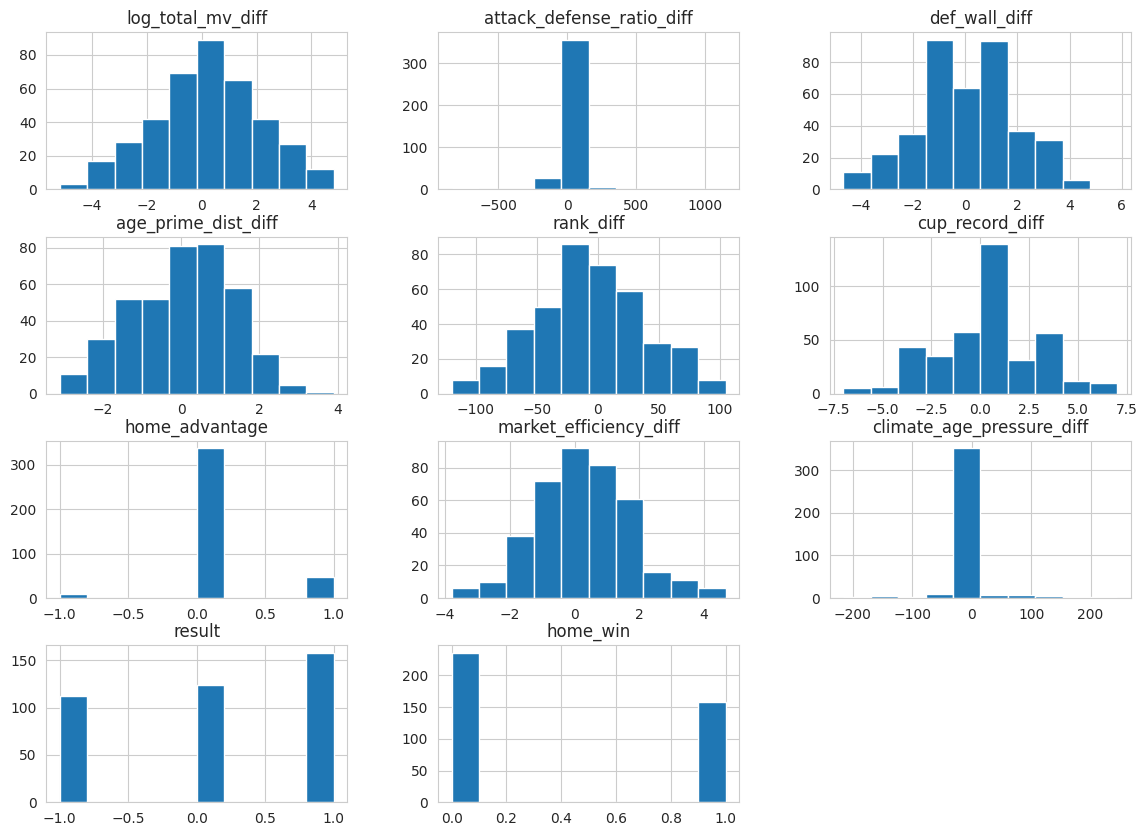

In [ ]:
imputed_final_df.hist(figsize=(14, 10))
plt.show()

## Heatmap

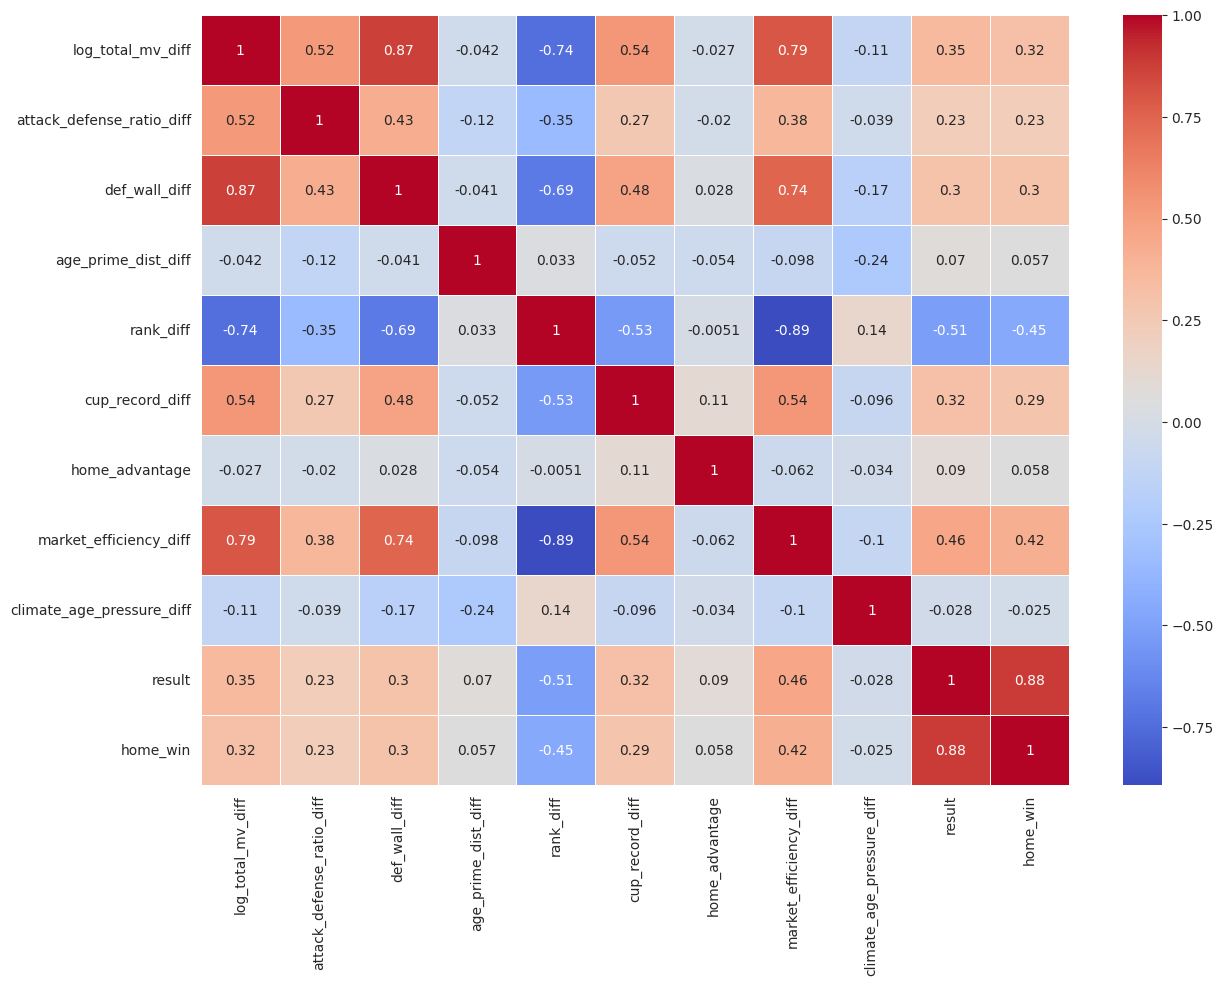

In [ ]:
num_col = imputed_final_df.select_dtypes(include=[np.number]).columns.tolist()
correlation = imputed_final_df[num_col].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation, cmap='coolwarm', annot=True, linewidth=.5)
plt.show()

# **Modeling**

Now, we come to the most important part is modeling, I've thaught of two models one to predict the home winning and other one wheter it's home win, draw or lose

In [ ]:
X = imputed_final_df.drop(columns=['home_win', 'result'])
y_r = imputed_final_df["result"]
y_h = imputed_final_df["home_win"]

In [ ]:
X.head()

,log_total_mv_diff,attack_defense_ratio_diff,def_wall_diff,age_prime_dist_diff,rank_diff,cup_record_diff,home_advantage,market_efficiency_diff,climate_age_pressure_diff
0,-1.613169,-8.663320,-1.329478,-0.8,21,0,1,-0.622156,81.728571
1,2.127067,15.518886,2.166505,-0.2,-20,3,0,1.640521,0.000000
2,2.127067,15.518886,2.166505,-0.2,-20,3,0,1.640521,0.000000
3,-3.312916,-29.521774,-3.560528,0.3,51,-2,0,-1.728434,-0.000000
4,-1.215463,-4.968653,-0.914910,0.3,-23,4,0,2.248743,0.000000


## Data Scaling and Splitting

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_r_train, y_r_test = train_test_split(X_scaled, y_r, test_size=0.3, random_state=42)
X_train, X_test, y_h_train, y_h_test = train_test_split(X_scaled, y_h, test_size=0.3, random_state=42)

In [ ]:
# train_mask = imputed_final_df["year"] < 2022
# test_mask  = imputed_final_df["year"] >= 2022

# X_train, X_test = X[train_mask], X[test_mask]
# y_train, y_test = y[train_mask], y[test_mask]

In [ ]:
len(X_train), len(y_r_train), len(X_test), len(y_r_test)

(275, 275, 119, 119)

## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf_r = RandomForestClassifier(n_estimators=42, oob_score=True)
rf_h = RandomForestClassifier(n_estimators=42, oob_score=True)

rf_r.fit(X_train,y_r_train)
rf_h.fit(X_train,y_h_train)

RandomForestClassifier(n_estimators=42, oob_score=True)

In [ ]:
print(rf_r.oob_score_,rf_h.oob_score_)

0.6072727272727273 0.7381818181818182


In [ ]:
print(rf_r.score(X_test, y_r_test), rf_h.score(X_test, y_h_test))

0.6218487394957983 0.7563025210084033


I've observe that the home winning model arrive to predict more accuratly the result

In [ ]:
y_r_pred = rf_r.predict(X_test)
y_h_pred = rf_h.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  cm_display = ConfusionMatrixDisplay(cm)
  plt.figure(figsize=(8, 4))
  cm_display.plot(cmap=plt.cm.Blues)
  plt.show()

### Confusion Matrix

<Figure size 800x400 with 0 Axes>

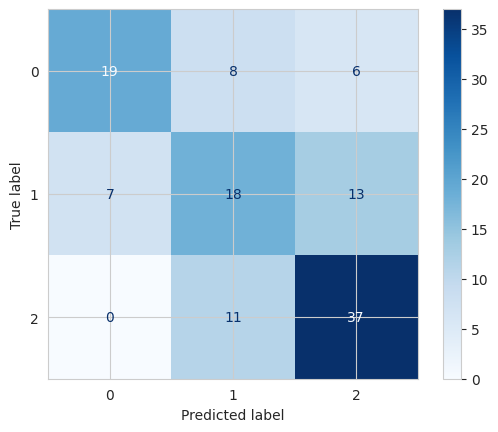

In [ ]:
plot_confusion_matrix(y_r_test, y_r_pred)

<Figure size 800x400 with 0 Axes>

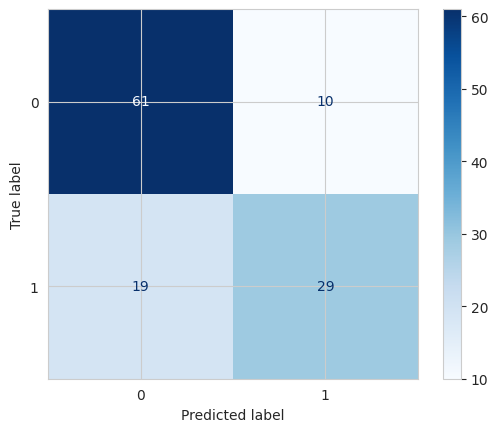

In [ ]:
plot_confusion_matrix(y_h_test, y_h_pred)

### Log Loss and Classification Report

In [ ]:
from sklearn.metrics import log_loss

# Get probability predictions for the multiclass result
y_r_proba_pred = rf_r.predict_proba(X_test)
# Get probability predictions for the binary home_win result (probability of class 1)
y_h_proba_pred = rf_h.predict_proba(X_test)[:, 1]

print("Log loss (multiclass result):", log_loss(y_r_test, y_r_proba_pred, labels=[-1, 0, 1]))
print("Log loss (binary home_win):", log_loss(y_h_test, y_h_proba_pred))

Log loss (multiclass result): 1.385863914297433
Log loss (binary home_win): 0.4490974101095925


In [ ]:
from sklearn.metrics import classification_report

y_h_pred2 = (y_h_proba_pred >= 0.4).astype(int)
print(classification_report(y_h_test, y_h_pred2))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        71
           1       0.72      0.81      0.76        48

    accuracy                           0.80       119
   macro avg       0.79      0.80      0.79       119
weighted avg       0.81      0.80      0.80       119



### ROC Best Threshold

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.3, 0.7, 41)
scores = []

for t in thresholds:
    scores.append(f1_score(y_h_test, (y_h_proba_pred >= t).astype(int)))

best_t = thresholds[np.argmax(scores)]
print("Best threshold:", best_t)

Best threshold: 0.39999999999999997


## SVM

In [ ]:
from sklearn.svm import SVC

svm_r = SVC(kernel='linear')
svm_h = SVC(kernel='linear')

svm_r.fit(X_train,y_r_train)
svm_h.fit(X_train,y_h_train)

SVC(kernel='linear')

In [ ]:
print(svm_r.score(X_test, y_r_test), svm_h.score(X_test, y_h_test))

0.5546218487394958 0.7142857142857143


In [ ]:
y_h_pred_svm = svm_h.predict(X_test)
y_r_pred_svm = svm_r.predict(X_test)

### Confusion Matrix

<Figure size 800x400 with 0 Axes>

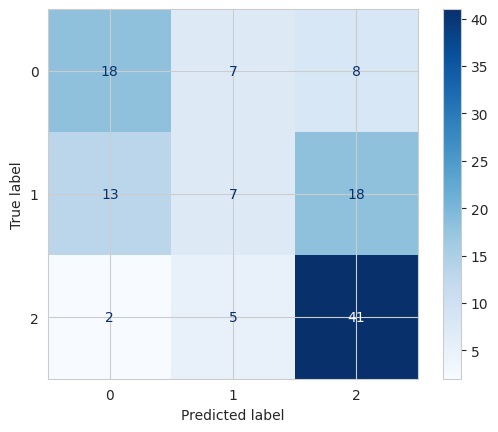

In [ ]:
plot_confusion_matrix(y_r_test, y_r_pred_svm)

<Figure size 800x400 with 0 Axes>

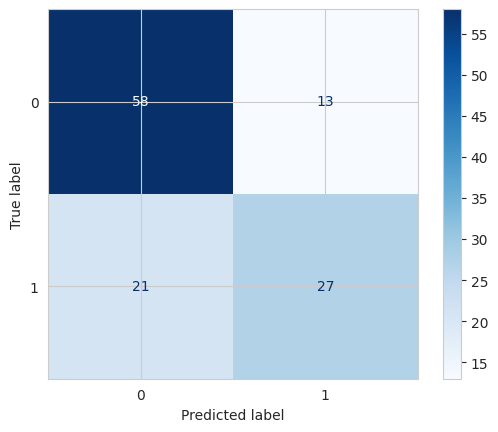

In [ ]:
plot_confusion_matrix(y_h_test, y_h_pred_svm)

# **AFCON 2025 Dataset**

Now, let's perform a simulation of the tournament but we need first to get the teams participating with their stats for 2025

Here is the teams participating in the tournament

In [ ]:
afcon_2025_teams = [
    ("Morocco", "MAR"),
    ("Burkina Faso", "BFA"),
    ("Cameroon", "CMR"),
    ("Algeria", "ALG"),
    ("DR Congo", "COD"),
    ("Senegal", "SEN"),
    ("Egypt", "EGY"),
    ("Angola", "ANG"),
    ("Equatorial Guinea", "EQG"),
    ("Côte d'Ivoire", "CIV"),
    ("Uganda", "UGA"),
    ("South Africa", "RSA"),
    ("Gabon", "GAB"),
    ("Tunisia", "TUN"),
    ("Nigeria", "NGA"),
    ("Zambia", "ZAM"),
    ("Mali", "MLI"),
    ("Zimbabwe", "ZIM"),
    ("Comoros", "COM"),
    ("Sudan", "SDN"),
    ("Benin", "BEN"),
    ("Tanzania", "TAN"),
    ("Botswana", "BOT"),
    ("Mozambique", "MOZ"),
]

In [ ]:
df_afcon_2025 = pd.DataFrame(
    afcon_2025_teams,
    columns=["team", "abbrv"]
)

In [ ]:
df_afcon_2025.head()

,team,abbrv
0,Morocco,MAR
1,Burkina Faso,BFA
2,Cameroon,CMR
3,Algeria,ALG
4,DR Congo,COD


## Ranks

Get the rank of teams, luckly I have saved these ranks beforehand

In [ ]:
ranking_df = pd.read_csv("./Data/afcon_team_rank-2010_2025.csv")
ranking_df.head()

In [ ]:
df_afcon_2025['rank'] = df_afcon_2025.apply(
    lambda row: ranking_df[
        (ranking_df['year'] == 2025) & (ranking_df['country_code'] == row['abbrv'])
    ]['rank'].values[0],
    axis=1
)

In [ ]:
df_afcon_2025.sample(5)

,team,abbrv,rank
4,DR Congo,COD,56
23,Mozambique,MOZ,102
20,Benin,BEN,92
0,Morocco,MAR,11
8,Equatorial Guinea,EQG,97


## TransferMarket Stats for 2025

Do you remember that transfermarket needs team ids to query the stats, luckly we have them in the final dataset we saved before

In [ ]:
df_afcon_2025['team_id'] = df_afcon_2025['abbrv'].apply(lambda x: countries_id_name_transfermarket_abrv.get(x))
df_afcon_2025['year'] = 2025

In [ ]:
df_afcon_2025.sample(5)

,team,abbrv,rank,team_id,year
8,Equatorial Guinea,EQG,97,13485,2025
4,DR Congo,COD,56,3854,2025
14,Nigeria,NGA,38,3444,2025
12,Gabon,GAB,78,5704,2025
16,Mali,MLI,54,3674,2025


### Query the Stats

In [ ]:
stast_2025 = []

for team, team_id in countries_id_name_transfermarket.items():
    print(f"Fetching stats for, {team}, ({team_id})")
    for year in ['2025']:
        stats = get_team_stats(team_id, year)
        if stats:
            stast_2025.append(stats)
    time.sleep(2)

Fetching stats for, Angola, (3585)
Fetching stats for, Ivory Coast, (3591)
Fetching stats for, Malawi, (8988)
Fetching stats for, Egypt, (3672)
Fetching stats for, Mozambique, (5129)
Fetching stats for, Cameroon, (3434)
Fetching stats for, Zambia, (3703)
Fetching stats for, Mali, (3674)
Fetching stats for, Nigeria, (3444)
Fetching stats for, Gabon, (5704)
Fetching stats for, Burkina Faso, (5872)
Fetching stats for, Algeria, (3614)
Fetching stats for, Ghana, (3441)
Fetching stats for, Equatorial Guinea, (13485)
Fetching stats for, Senegal, (3499)
Fetching stats for, Morocco, (3575)
Fetching stats for, Libya, (6602)
Fetching stats for, Sudan, (13313)
Fetching stats for, Niger, (3444)
Fetching stats for, Botswana, (15229)
Fetching stats for, South Africa, (3806)
Fetching stats for, Tunisia, (3670)
Fetching stats for, Cape Verde, (4311)
Fetching stats for, DR Congo, (3854)
Fetching stats for, Ethiopia, (13941)
Fetching stats for, Togo, (3815)
Fetching stats for, Congo, (3854)
Fetching stat

In [ ]:
# Create single DataFrame
afcon_teams_stast_2025 = pd.DataFrame(stast_2025)
afcon_teams_stast_2025.head()

,team_id,year,goalkeeper_avg_age,goalkeeper_market_value,defender_avg_age,defender_market_value,attack_avg_age,attack_market_value,total_avg_age,total_market_value
0,3585,2025,34.5,400000.0,28.9,22300000.0,28.2,22900000.0,28.8,55230000.0
1,3591,2025,25.4,8800000.0,27.4,146400000.0,24.9,169000000.0,26.5,374300000.0
2,8988,2025,25.8,75000.0,27.0,300000.0,26.7,425000.0,26.5,1980000.0
3,3672,2025,31.0,2600000.0,29.0,7300000.0,28.7,113300000.0,28.9,136400000.0
4,5129,2025,26.0,325000.0,29.5,7550000.0,28.8,1050000.0,29.0,24800000.0


### Merging the Data

In [ ]:
df_afcon_2025 = (
    df_afcon_2025
    .merge(
        pd.DataFrame(stast_2025).astype({'year': int}),
        on=["team_id", "year"],
        how="inner"
    )
)

In [ ]:
df_afcon_2025.sample(5)

,team,abbrv,rank,team_id,year,goalkeeper_avg_age,goalkeeper_market_value,defender_avg_age,defender_market_value,attack_avg_age,attack_market_value,total_avg_age,total_market_value
3,Algeria,ALG,35,3614,2025,29.3,2900000.0,27.0,71200000.0,27.0,78500000.0,26.8,235600000.0
17,Zambia,ZAM,90,3703,2025,26.5,250000.0,27.5,1380000.0,24.3,14750000.0,25.6,21530000.0
4,DR Congo,COD,56,3854,2025,26.3,6400000.0,29.2,40200000.0,28.7,32600000.0,27.7,131900000.0
25,Mozambique,MOZ,102,5129,2025,26.0,325000.0,29.5,7550000.0,28.8,1050000.0,29.0,24800000.0
14,Tunisia,TUN,40,3670,2025,29.2,2550000.0,29.8,15550000.0,28.2,24050000.0,28.7,69050000.0


## AFCON Win Record and Host

In [ ]:
df_afcon_2025['cup_win_record'] = df_afcon_2025['abbrv'].apply(lambda x: afcon_winners_record.get(x,0))

In [ ]:
df_afcon_2025['hosting'] = (df_afcon_2025['abbrv'] == 'MAR').astype(int)

In [ ]:
df_afcon_2025.sample(5)

,team,abbrv,rank,team_id,year,goalkeeper_avg_age,goalkeeper_market_value,defender_avg_age,defender_market_value,attack_avg_age,attack_market_value,total_avg_age,total_market_value,cup_win_record,hosting
2,Cameroon,CMR,57,3434,2025,27.7,2250000.0,25.2,44500000.0,26.1,131200000.0,25.6,262250000.0,5,0
7,Angola,ANG,89,3585,2025,34.5,400000.0,28.9,22300000.0,28.2,22900000.0,28.8,55230000.0,0,0
4,DR Congo,COD,56,3854,2025,26.3,6400000.0,29.2,40200000.0,28.7,32600000.0,27.7,131900000.0,2,0
0,Morocco,MAR,11,3575,2025,32.2,4950000.0,29.2,151500000.0,25.5,146000000.0,27.4,416450000.0,1,1
20,Comoros,COM,108,16430,2025,27.7,625000.0,26.8,5050000.0,27.4,5150000.0,27.0,18850000.0,0,0


## Weather Condition

In [ ]:
weather_mar = get_afcon_host_weather('MAR', year=2025, month=11, day=31)
print(weather_mar)

{'host_country': 'MAR', 'capital': 'Rabat', 'avg_temp_host': np.float64(17.139285714285712), 'avg_humidity_host': np.float64(76.96428571428571)}


In [ ]:
df_afcon_2025["avg_temp_host"] = weather_mar['avg_temp_host']
df_afcon_2025["avg_humidity_host"] = weather_mar['avg_humidity_host']

In [ ]:
df_afcon_2025.sample(5)

,team,abbrv,rank,team_id,year,goalkeeper_avg_age,goalkeeper_market_value,defender_avg_age,defender_market_value,attack_avg_age,attack_market_value,total_avg_age,total_market_value,cup_win_record,hosting,avg_temp_host,avg_humidity_host
22,Benin,BEN,92,3955,2025,29.7,225000.0,27.2,3730000.0,25.8,5230000.0,26.0,13380000.0,0,0,17.139286,76.964286
24,Botswana,BOT,138,15229,2025,31.5,100000.0,29.0,1100000.0,26.8,475000.0,29.1,1950000.0,0,0,17.139286,76.964286
0,Morocco,MAR,11,3575,2025,32.2,4950000.0,29.2,151500000.0,25.5,146000000.0,27.4,416450000.0,1,1,17.139286,76.964286
10,Côte d'Ivoire,CIV,42,3591,2025,25.4,8800000.0,27.4,146400000.0,24.9,169000000.0,26.5,374300000.0,3,0,17.139286,76.964286
19,Zimbabwe,ZIM,129,3583,2025,34.6,75000.0,28.1,4830000.0,26.0,2530000.0,27.9,10100000.0,0,0,17.139286,76.964286


## Group Stage Dataset

Now after preparing the teams raw information, let's create another dataset that holds the group stage games

In [ ]:
matches = [
    # Group A
    ("A", "2025-12-21", "MAR", "COM"),
    ("A", "2025-12-22", "MLI", "ZAM"),
    ("A", "2025-12-26", "MAR", "MLI"),
    ("A", "2025-12-26", "ZAM", "COM"),
    ("A", "2025-12-29", "MAR", "ZAM"),
    ("A", "2025-12-29", "COM", "MLI"),

    # Group B
    ("B", "2025-12-22", "EGY", "ZIM"),
    ("B", "2025-12-22", "RSA", "ANG"),
    ("B", "2025-12-26", "EGY", "RSA"),
    ("B", "2025-12-26", "ANG", "ZIM"),
    ("B", "2025-12-29", "EGY", "ANG"),
    ("B", "2025-12-29", "ZIM", "RSA"),

    # Group C
    ("C", "2025-12-23", "NGA", "TAN"),
    ("C", "2025-12-23", "TUN", "UGA"),
    ("C", "2025-12-27", "NGA", "TUN"),
    ("C", "2025-12-27", "UGA", "TAN"),
    ("C", "2025-12-30", "NGA", "UGA"),
    ("C", "2025-12-30", "TAN", "TUN"),

    # Group D
    ("D", "2025-12-23", "SEN", "BOT"),
    ("D", "2025-12-23", "COD", "BEN"),
    ("D", "2025-12-27", "COD", "SEN"),
    ("D", "2025-12-27", "BEN", "BOT"),
    ("D", "2025-12-30", "BOT", "COD"),
    ("D", "2025-12-30", "BEN", "SEN"),

    # Group E
    ("E", "2025-12-24", "ALG", "SDN"),
    ("E", "2025-12-24", "BFA", "EQG"),
    ("E", "2025-12-28", "ALG", "BFA"),
    ("E", "2025-12-28", "EQG", "SDN"),
    ("E", "2025-12-31", "EQG", "ALG"),
    ("E", "2025-12-31", "BFA", "SDN"),

    # Group F
    ("F", "2025-12-24", "CIV", "MOZ"),
    ("F", "2025-12-24", "CMR", "GAB"),
    ("F", "2025-12-28", "CMR", "CIV"),
    ("F", "2025-12-28", "GAB", "MOZ"),
    ("F", "2025-12-31", "CMR", "MOZ"),
    ("F", "2025-12-31", "CIV", "GAB"),
]

df_group_stage = pd.DataFrame(
    matches,
    columns=["group", "date", "home", "away"]
)

Here is an overview

In [ ]:
print(df_group_stage.sample(5))

   group        date home away
6      B  2025-12-22  EGY  ZIM
8      B  2025-12-26  EGY  RSA
32     F  2025-12-28  CMR  CIV
20     D  2025-12-27  COD  SEN
33     F  2025-12-28  GAB  MOZ


In [ ]:
df_afcon_2025.columns

Index(['team', 'abbrv', 'rank', 'team_id', 'year', 'goalkeeper_avg_age',
       'goalkeeper_market_value', 'defender_avg_age', 'defender_market_value',
       'attack_avg_age', 'attack_market_value', 'total_avg_age',
       'total_market_value', 'cup_win_record', 'hosting', 'avg_temp_host',
       'avg_humidity_host'],
      dtype='object')

saving the data for future use

In [ ]:
df_afcon_2025.to_csv('df_afcon_2025.csv', index=False)
df_group_stage.to_csv('df_group_stage.csv', index=False)

### Data Transformation

Now that we have all the required data, we need to transform the to the baseline dataset

In [ ]:
def build_afcon_2025_matches(df_group_stage, df_afcon_2025):
    # --- Base match dataframe ---
    df = df_group_stage.copy()

    df['date'] = pd.to_datetime(df['date'])
    df['tournament'] = 'AFCON'

    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    df = df.rename(columns={
        'home': 'home_abrv',
        'away': 'away_abrv'
    })

    # --- Prepare team lookup ---
    team_cols = [
        'team', 'abbrv', 'rank', 'team_id', 'cup_win_record',
        'hosting', 'avg_temp_host', 'avg_humidity_host',
        'goalkeeper_avg_age', 'goalkeeper_market_value',
        'defender_avg_age', 'defender_market_value',
        'attack_avg_age', 'attack_market_value',
        'total_avg_age', 'total_market_value'
    ]

    teams = df_afcon_2025[team_cols].copy()

    # --- Merge HOME team ---
    df = df.merge(
        teams.add_prefix('home_'),
        left_on='home_abrv',
        right_on='home_abbrv',
        how='left'
    )

    # --- Merge AWAY team ---
    df = df.merge(
        teams.add_prefix('away_'),
        left_on='away_abrv',
        right_on='away_abbrv',
        how='left'
    )

    # --- Hosting (ONLY MAR) ---
    df['is_home_hosting'] = (df['home_abrv'] == 'MAR').astype(int)
    df['is_away_hosting'] = (df['away_abrv'] == 'MAR').astype(int)

    df['hosted_country'] = 'MAR'



    # --- Final rename for clarity ---
    df = df.rename(columns={
        'home_team': 'home_team',
        'away_team': 'away_team',
        'home_rank': 'home_rank',
        'away_rank': 'away_rank',
        'home_team_id': 'home_id',
        'away_team_id': 'away_id',
        'home_cup_win_record': 'home_cup_win_record',
        'away_cup_win_record': 'away_cup_win_record',
        'home_avg_temp_host': 'avg_temp_host',
        'home_avg_humidity_host': 'avg_humidity_host'
    })

    # --- Select final columns (NO scores included) ---
    final_cols = [
        'group', 'date', 'home_team', 'away_team',
        'tournament', 'home_abrv', 'away_abrv',
        'year', 'month', 'day',
        'home_rank', 'away_rank',
        'home_cup_win_record', 'away_cup_win_record',
        'is_home_hosting', 'is_away_hosting',
        'hosted_country',
        'avg_temp_host', 'avg_humidity_host',
        'home_id', 'away_id',
        'home_goalkeeper_avg_age', 'home_goalkeeper_market_value',
        'home_defender_avg_age', 'home_defender_market_value',
        'home_attack_avg_age', 'home_attack_market_value',
        'home_total_avg_age', 'home_total_market_value',
        'away_goalkeeper_avg_age', 'away_goalkeeper_market_value',
        'away_defender_avg_age', 'away_defender_market_value',
        'away_attack_avg_age', 'away_attack_market_value',
        'away_total_avg_age', 'away_total_market_value'
    ]

    return df[final_cols]

In [ ]:
df_afcon_matches_2025 = build_afcon_2025_matches(
    df_group_stage,
    df_afcon_2025
)

In [ ]:
df_afcon_matches_2025.sample(5)

,group,date,home_team,away_team,tournament,home_abrv,away_abrv,year,month,day,...,home_total_avg_age,home_total_market_value,away_goalkeeper_avg_age,away_goalkeeper_market_value,away_defender_avg_age,away_defender_market_value,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value
41,F,2025-12-31,Côte d'Ivoire,Gabon,AFCON,CIV,GAB,2025,12,31,...,26.5,374300000.0,25.8,175000.0,26.8,8150000.0,29.0,14130000.0,28.0,31350000.0
22,D,2025-12-23,DR Congo,Benin,AFCON,COD,BEN,2025,12,23,...,27.7,131900000.0,29.7,225000.0,27.2,3730000.0,25.8,5230000.0,26.0,13380000.0
13,C,2025-12-23,Nigeria,Tanzania,AFCON,NGA,TAN,2025,12,23,...,27.4,285800000.0,27.8,75000.0,27.0,950000.0,28.3,2180000.0,26.9,6330000.0
26,D,2025-12-30,Benin,Senegal,AFCON,BEN,SEN,2025,12,30,...,26.0,13380000.0,30.8,14500000.0,26.7,83500000.0,27.3,191500000.0,27.3,410900000.0
18,C,2025-12-30,Nigeria,Uganda,AFCON,NGA,UGA,2025,12,30,...,27.4,285800000.0,33.3,925000.0,28.1,2200000.0,27.1,1650000.0,28.0,7130000.0


save the dataset

In [ ]:
df_afcon_matches_2025.to_csv('./Data/df_afcon_matches_2025.csv', index=False)

In [ ]:
df_afcon_matches_2025 = pd.read_csv('/content/df_afcon_matches_2025.csv')

In [ ]:
df_afcon_matches_2025.sample(5)

,group,date,home_team,away_team,tournament,home_abrv,away_abrv,year,month,day,...,home_total_avg_age,home_total_market_value,away_goalkeeper_avg_age,away_goalkeeper_market_value,away_defender_avg_age,away_defender_market_value,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value
19,C,2025-12-30,Nigeria,Uganda,AFCON,NGA,UGA,2025,12,30,...,27.4,285800000.0,33.3,925000.0,28.1,2200000.0,27.1,1650000.0,28.0,7130000.0
1,A,2025-12-22,Mali,Zambia,AFCON,MLI,ZAM,2025,12,22,...,26.2,143350000.0,26.5,250000.0,27.5,1380000.0,24.3,14750000.0,25.6,21530000.0
13,C,2025-12-23,Nigeria,Tanzania,AFCON,NGA,TAN,2025,12,23,...,27.4,285800000.0,27.8,75000.0,27.0,950000.0,28.3,2180000.0,26.9,6330000.0
2,A,2025-12-26,Morocco,Mali,AFCON,MAR,MLI,2025,12,26,...,27.4,416450000.0,32.6,850000.0,26.5,23100000.0,23.1,44900000.0,26.2,143350000.0
40,F,2025-12-31,Côte d'Ivoire,Gabon,AFCON,CIV,GAB,2025,12,31,...,26.5,374300000.0,25.8,175000.0,26.8,8150000.0,29.0,14130000.0,28.0,31350000.0


In [ ]:
df_afcon_matches_2025.duplicated().sum()

In [ ]:
df_afcon_matches_2025 = df_afcon_matches_2025.drop_duplicates()

In [ ]:
df_afcon_matches_2025.duplicated().sum()

np.int64(0)

### Feature Engeneering Application

In [ ]:
drop_cols2 = [
        'group', 'date','tournament','home_id','away_id',
        "home_total_market_value", "away_total_market_value",
        "home_attack_market_value", "away_attack_market_value",
        "home_defender_market_value", "away_defender_market_value",
        "home_goalkeeper_market_value", "away_goalkeeper_market_value",
        "home_total_avg_age", "away_total_avg_age",
        "home_attack_avg_age", "away_attack_avg_age",
        "home_defender_avg_age", "away_defender_avg_age",
        "home_goalkeeper_avg_age", "away_goalkeeper_avg_age",
        "home_rank", "away_rank",
        "home_cup_win_record", "away_cup_win_record",
        "is_home_hosting", "is_away_hosting",
        "avg_temp_host", "avg_humidity_host",
        "hosted_country", "home_team", "away_team",
         "year","month", "day",
        "home_abrv", "away_abrv",
    ]

In [ ]:
temp_df_afcon_matches_2025 = df_afcon_matches_2025.drop_duplicates().copy()
df_afcon_2025_final = engineer_football_features(temp_df_afcon_matches_2025, drop_cols=drop_cols2)

In [ ]:
df_afcon_2025_final.duplicated().sum()

np.int64(0)

In [ ]:
df_afcon_2025_final.to_csv('df_afcon_2025_final.csv', index=False)

In [ ]:
df_afcon_2025_final = pd.read_csv('./Data/df_afcon_2025_final.csv')

In [ ]:
df_afcon_2025_final.sample(5)

# **AFCON 2025 Simulation**

## Group Stage

In [ ]:
scaled_afcon_2025 = scaler.transform(df_afcon_2025_final)

In [ ]:
simuted_rs_r = rf_r.predict(scaled_afcon_2025)
simuted_rs_h = rf_h.predict(scaled_afcon_2025)

In [ ]:
df_afcon_matches_2025_predicted = df_afcon_matches_2025.copy()
df_afcon_matches_2025_predicted['predicted_home'] = simuted_rs_h
df_afcon_matches_2025_predicted['predicted_result'] = simuted_rs_r

In [ ]:
df_afcon_matches_2025_predicted.head(6)

,group,date,home_team,away_team,tournament,home_abrv,away_abrv,year,month,day,...,away_goalkeeper_avg_age,away_goalkeeper_market_value,away_defender_avg_age,away_defender_market_value,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value,predicted_home,predicted_result
0,A,2025-12-21,Morocco,Comoros,AFCON,MAR,COM,2025,12,21,...,27.7,625000.0,26.8,5050000.0,27.4,5150000.0,27.0,18850000.0,1,1
1,A,2025-12-22,Mali,Zambia,AFCON,MLI,ZAM,2025,12,22,...,26.5,250000.0,27.5,1380000.0,24.3,14750000.0,25.6,21530000.0,1,1
2,A,2025-12-26,Morocco,Mali,AFCON,MAR,MLI,2025,12,26,...,32.6,850000.0,26.5,23100000.0,23.1,44900000.0,26.2,143350000.0,1,1
3,A,2025-12-26,Zambia,Comoros,AFCON,ZAM,COM,2025,12,26,...,27.7,625000.0,26.8,5050000.0,27.4,5150000.0,27.0,18850000.0,0,1
4,A,2025-12-29,Morocco,Zambia,AFCON,MAR,ZAM,2025,12,29,...,26.5,250000.0,27.5,1380000.0,24.3,14750000.0,25.6,21530000.0,1,1
5,A,2025-12-29,Comoros,Mali,AFCON,COM,MLI,2025,12,29,...,32.6,850000.0,26.5,23100000.0,23.1,44900000.0,26.2,143350000.0,0,-1


In [ ]:
df_afcon_matches_2025.to_csv('df_afcon_matches_2025_predicted.csv', index=False)

### Monte Carlo Simulation for Game Outcome

In [ ]:
def monte_carlo_group_predictions(
    matches_df: pd.DataFrame,
    X_features: pd.DataFrame,
    scaler,
    winner_model,               # binary home_win model
    wdl_model,                  # {-1, 0, 1} model
    n_simulations: int = 10_000,
    noise_level: float = 0.05,
    binary_features=["home_advantage", "cup_record_diff"],
    random_state: int = 42,
):
    rng = np.random.default_rng(random_state)
    features = X_features.columns

    winner_probs = []
    wdl_probs = []

    for _ in range(n_simulations):
        X_sim = X_features.copy()

        # Add noise
        for col in features:
            if col in binary_features:
                continue
            X_sim[col] += rng.normal(0, noise_level, size=len(X_sim))

        X_sim_scaled = scaler.transform(X_sim)

        # Binary home-win model → P(home win)
        winner_probs.append(
            winner_model.predict_proba(X_sim_scaled)[:, 1]
        )

        # W/D/L model → classes [-1, 0, 1]
        wdl_probs.append(
            wdl_model.predict_proba(X_sim_scaled)
        )

    winner_probs = np.array(winner_probs)
    wdl_probs = np.array(wdl_probs)

    # Aggregate Monte-Carlo results
    output = matches_df.copy()

    # From home-win model
    output["p_home_win_bin"] = winner_probs.mean(axis=0)
    output["p_home_win_bin_std"] = winner_probs.std(axis=0)

    # From W/D/L model (respect class order!)
    output["p_away_win"] = wdl_probs.mean(axis=0)[:, 0]  # -1
    output["p_draw"]     = wdl_probs.mean(axis=0)[:, 1]  #  0
    output["p_home_win"] = wdl_probs.mean(axis=0)[:, 2]  #  1

    # Final predicted result (your encoding)
    output["predicted_result"] = np.select(
        [
            output["p_home_win"] >= output["p_draw"],
            output["p_draw"] > output["p_away_win"],
        ],
        [1, 0],
        default=-1
    )

    return output

In [ ]:
pred_df = monte_carlo_group_predictions(
    matches_df=temp_df_afcon_matches_2025,
    X_features=df_afcon_2025_final,
    scaler=scaler,
    winner_model=rf_h,
    wdl_model=rf_r,
    n_simulations=10000,
    noise_level=0.05,
    random_state=42
)

In [ ]:
pred_df[pred_df['group'] == 'Ag']

,group,date,home_team,away_team,tournament,home_abrv,away_abrv,year,month,day,...,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value,p_home_win_bin,p_home_win_bin_std,p_away_win,p_draw,p_home_win,predicted_result
0,A,2025-12-21,Morocco,Comoros,AFCON,MAR,COM,2025,12,21,...,27.4,5150000.0,27.0,18850000.0,0.823076,0.022137,0.000000,0.045702,0.954298,1
1,A,2025-12-22,Mali,Zambia,AFCON,MLI,ZAM,2025,12,22,...,24.3,14750000.0,25.6,21530000.0,0.574395,0.019049,0.023855,0.489602,0.486543,0
2,A,2025-12-26,Morocco,Mali,AFCON,MAR,MLI,2025,12,26,...,23.1,44900000.0,26.2,143350000.0,0.669302,0.020719,0.085619,0.165040,0.749340,1
3,A,2025-12-26,Zambia,Comoros,AFCON,ZAM,COM,2025,12,26,...,27.4,5150000.0,27.0,18850000.0,0.492560,0.058159,0.229019,0.247345,0.523636,1
4,A,2025-12-29,Morocco,Zambia,AFCON,MAR,ZAM,2025,12,29,...,24.3,14750000.0,25.6,21530000.0,0.879731,0.005253,0.025517,0.116362,0.858121,1
5,A,2025-12-29,Comoros,Mali,AFCON,COM,MLI,2025,12,29,...,23.1,44900000.0,26.2,143350000.0,0.166826,0.019417,0.824183,0.148967,0.026850,-1


### Monte Carlo Simulation for Group Standings

In [ ]:
def simulate_group_standings(
    pred_df: pd.DataFrame,
    n_simulations: int = 10_000,
    random_state: int = 42,
):
    rng = np.random.default_rng(random_state)
    groups = pred_df["group"].unique()

    qualify_count = {}

    for _ in range(n_simulations):
        for g in groups:
            gdf = pred_df[pred_df["group"] == g]
            points = {}

            for _, row in gdf.iterrows():
                h, a = row["home_team"], row["away_team"]
                points.setdefault(h, 0)
                points.setdefault(a, 0)

                outcome = rng.choice(
                    [-1, 0, 1],
                    p=[row["p_away_win"], row["p_draw"], row["p_home_win"]]
                )

                if outcome == 1:
                    points[h] += 3
                elif outcome == -1:
                    points[a] += 3
                else:
                    points[h] += 1
                    points[a] += 1

            ranked = sorted(points.items(), key=lambda x: x[1], reverse=True)

            for team, _ in ranked[:2]:
                qualify_count[team] = qualify_count.get(team, 0) + 1

    return (
        pd.Series(qualify_count)
        .div(n_simulations)
        .rename("qualification_probability")
        .sort_values(ascending=False)
    )

In [ ]:
group_qual_probs = simulate_group_standings(
    pred_df,
    n_simulations=10_000,
    random_state=42
)

In [ ]:
group_qual_probs

,qualification_probability
Morocco,0.9911
Egypt,0.9420
Algeria,0.9410
Nigeria,0.9338
Senegal,0.9009
Mali,0.8551
Côte d'Ivoire,0.7542
Cameroon,0.7408
Tunisia,0.7041
Burkina Faso,0.6587


### Group Final Standings

In [ ]:
teams_df = pd.DataFrame(
    afcon_2025_teams,
    columns=["team", "abbrv"]
)

In [ ]:
for group in df_group_stage['group'].unique():
    teams = pd.concat([df_group_stage[df_group_stage['group'] == group]['home'],
                       df_group_stage[df_group_stage['group'] == group]['away']]).unique()

    teams_df.loc[teams_df['abbrv'].isin(teams), 'group'] = group

In [ ]:
group_stage_rank = teams_df.merge(group_qual_probs, left_on='team', right_index=True)

In [ ]:
group_stage_rank = group_stage_rank.sort_values(by=['group', 'qualification_probability'], ascending=[True, False])

In [ ]:
for group in group_stage_rank['group'].unique():
  print(f"Final Standings for group {group}")
  print(group_stage_rank[group_stage_rank['group'] == group])
  print('-'*55)

Final Standings for group A
       team abbrv group  qualification_probability
0   Morocco   MAR     A                     0.9911
16     Mali   MLI     A                     0.8551
15   Zambia   ZAM     A                     0.0924
18  Comoros   COM     A                     0.0614
-------------------------------------------------------
Final Standings for group B
            team abbrv group  qualification_probability
6          Egypt   EGY     B                     0.9420
11  South Africa   RSA     B                     0.6522
7         Angola   ANG     B                     0.3165
17      Zimbabwe   ZIM     B                     0.0893
-------------------------------------------------------
Final Standings for group C
        team abbrv group  qualification_probability
14   Nigeria   NGA     C                     0.9338
13   Tunisia   TUN     C                     0.7041
21  Tanzania   TAN     C                     0.2054
10    Uganda   UGA     C                     0.1567
---------

## Knockout

In [ ]:
def monte_carlo_knockout_predictions(
    matches_df: pd.DataFrame,
    X_features: pd.DataFrame,
    scaler,
    winner_model,               # binary home_win model
    n_simulations: int = 10_000,
    noise_level: float = 0.05,
    binary_features=["home_advantage", "cup_record_diff"],
    random_state: int = 42,
):

    rng = np.random.default_rng(random_state)
    features = X_features.columns

    winner_probs = []

    for _ in range(n_simulations):
        X_sim = X_features.copy()

        # Add noise in standardized space
        for col in features:
            if col in binary_features:
                continue
            X_sim[col] += rng.normal(0, noise_level, size=len(X_sim))

        X_sim_scaled = scaler.transform(X_sim)

        # Binary home-win model → P(home win)
        winner_probs.append(
            winner_model.predict_proba(X_sim_scaled)[:, 1]
        )


    winner_probs = np.array(winner_probs)

    # Aggregate Monte-Carlo results
    output = matches_df.copy()

    # From home-win model
    output["p_home_win_bin"] = winner_probs.mean(axis=0)
    output["p_home_win_bin_std"] = winner_probs.std(axis=0)

    # From W/D/L model (respect class order!)
    output["p_away_win"] = np.nan
    output["p_draw"]     = np.nan
    output["p_home_win"] = np.nan

    # Final predicted result (your encoding)
    output["predicted_result"] = (output["p_home_win_bin"] > 0.5).astype(int)

    return output

### Round of 16 fixtures/results

In [ ]:
df_afcon_2025 = pd.read_csv('/content/df_afcon_2025.csv')

In [ ]:
data = {
    'group': ['D/3rd', 'A/C', 'A/3rd', 'B/F', 'B/3rd', 'C/3rd', 'E/D', 'F/E'],
    'date': [
        '2026-01-03', '2026-01-03',
        '2026-01-04', '2026-01-04',
        '2026-01-05', '2026-01-05',
        '2026-01-06', '2026-01-06'
    ],
    'home': ['SEN', 'MLI', 'MAR', 'RSA', 'EGY', 'NGA', 'ALG', 'CIV'],
    'away': ['BEN', 'TUN', 'SDN', 'CMR', 'ANG', 'MOZ', 'COD', 'BFA']
}

In [ ]:
df_r16 = pd.DataFrame(data)
df_r16.head()

,group,date,home,away
0,D/3rd,2026-01-03,SEN,BEN
1,A/C,2026-01-03,MLI,TUN
2,A/3rd,2026-01-04,MAR,SDN
3,B/F,2026-01-04,RSA,CMR
4,B/3rd,2026-01-05,EGY,ANG


In [ ]:
df_r16_teams_1vs1 = build_afcon_2025_matches(
    df_r16,
    df_afcon_2025
)

In [ ]:
df_r16_teams_1vs1.duplicated().sum()

np.int64(2)

In [ ]:
df_r16_teams_1vs1.drop_duplicates(inplace=True)

In [ ]:
df_r16_teams_1vs1.head()

,group,date,home_team,away_team,tournament,home_abrv,away_abrv,year,month,day,...,home_total_avg_age,home_total_market_value,away_goalkeeper_avg_age,away_goalkeeper_market_value,away_defender_avg_age,away_defender_market_value,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value
0,D/3rd,2026-01-03,Senegal,Benin,AFCON,SEN,BEN,2026,1,3,...,27.3,410900000.0,29.7,225000.0,27.2,3730000.0,25.8,5230000.0,26.0,13380000.0
1,A/C,2026-01-03,Mali,Tunisia,AFCON,MLI,TUN,2026,1,3,...,26.2,143350000.0,29.2,2550000.0,29.8,15550000.0,28.2,24050000.0,28.7,69050000.0
2,A/3rd,2026-01-04,Morocco,Sudan,AFCON,MAR,SDN,2026,1,4,...,27.4,416450000.0,31.0,75000.0,28.4,650000.0,27.8,775000.0,28.8,2280000.0
3,B/F,2026-01-04,South Africa,Cameroon,AFCON,RSA,CMR,2026,1,4,...,26.2,44450000.0,27.7,2250000.0,25.2,44500000.0,26.1,131200000.0,25.6,262250000.0
4,B/3rd,2026-01-05,Egypt,Angola,AFCON,EGY,ANG,2026,1,5,...,28.9,136400000.0,34.5,400000.0,28.9,22300000.0,28.2,22900000.0,28.8,55230000.0


In [ ]:
df_r16_teams_1vs1_final = engineer_football_features(df_r16_teams_1vs1, drop_cols=drop_cols2)

In [ ]:
df_r16_teams_1vs1_final.head()

,log_total_mv_diff,attack_defense_ratio_diff,def_wall_diff,age_prime_dist_diff,rank_diff,cup_record_diff,home_advantage,market_efficiency_diff,climate_age_pressure_diff
0,3.424589,51.277834,3.209987,-0.7,-73,1,0,3.000427,0.000
1,0.730458,1.846334,0.280056,-0.9,14,-1,0,-0.174033,-0.000
2,5.207591,224.609924,5.374319,-1.4,-107,0,1,4.923874,-131.745
3,-1.774933,-9.244361,-1.062894,-0.6,4,-4,0,-0.507210,0.000
4,0.904085,1.943731,-0.829830,0.1,-55,7,0,1.306703,0.000


In [ ]:
pred_16_df = monte_carlo_knockout_predictions(
    matches_df=df_r16_teams_1vs1,
    X_features=df_r16_teams_1vs1_final,
    scaler=scaler,
    winner_model=rf_h,
    n_simulations=10000,
    noise_level=0.05,
    random_state=42
)


In [ ]:
pred_16_df[['group','date','home_team','away_team','p_home_win_bin','predicted_result']].head(8)

,group,date,home_team,away_team,p_home_win_bin,predicted_result
0,D/3rd,2026-01-03,Senegal,Benin,0.985731,1
1,A/C,2026-01-03,Mali,Tunisia,0.402214,0
2,A/3rd,2026-01-04,Morocco,Sudan,0.916643,1
3,B/F,2026-01-04,South Africa,Cameroon,0.210995,0
4,B/3rd,2026-01-05,Egypt,Angola,0.643664,1
5,C/3rd,2026-01-05,Nigeria,Mozambique,0.548869,1
7,E/D,2026-01-06,Algeria,DR Congo,0.454028,0
8,F/E,2026-01-06,Côte d'Ivoire,Burkina Faso,0.199733,0


### Quarter-finals results

In [ ]:
qf_data = {
    'group': ['QF1', 'QF2', 'QF3', 'QF4'],
    'date': ['2026-01-09', '2026-01-09', '2026-01-10', '2026-01-10'],
    'home': ['TUN', 'CMR', 'COD', 'EGY'],
    'away': ['SEN', 'MAR', 'NGA', 'BFA']
}

In [ ]:
df_qf = pd.DataFrame(qf_data)
df_qf.head().

,group,date,home,away
0,QF1,2026-01-09,TUN,SEN
1,QF2,2026-01-09,CMR,MAR
2,QF3,2026-01-10,COD,NGA
3,QF4,2026-01-10,EGY,BFA


In [ ]:
df_qf_teams_1vs1 = build_afcon_2025_matches(
    df_qf,
    df_afcon_2025
)

In [ ]:
df_qf_teams_1vs1

,group,date,home_team,away_team,tournament,home_abrv,away_abrv,year,month,day,...,home_total_avg_age,home_total_market_value,away_goalkeeper_avg_age,away_goalkeeper_market_value,away_defender_avg_age,away_defender_market_value,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value
0,QF1,2026-01-09,Tunisia,Senegal,AFCON,TUN,SEN,2026,1,9,...,28.7,69050000.0,30.8,14500000.0,26.7,83500000.0,27.3,191500000.0,27.3,410900000.0
1,QF2,2026-01-09,Cameroon,Morocco,AFCON,CMR,MAR,2026,1,9,...,25.6,262250000.0,32.2,4950000.0,29.2,151500000.0,25.5,146000000.0,27.4,416450000.0
2,QF3,2026-01-10,DR Congo,Nigeria,AFCON,COD,NGA,2026,1,10,...,27.7,131900000.0,27.6,1100000.0,27.5,55100000.0,28.1,178300000.0,27.4,285800000.0
3,QF3,2026-01-10,DR Congo,Nigeria,AFCON,COD,NGA,2026,1,10,...,27.7,131900000.0,27.6,1100000.0,27.5,55100000.0,28.1,178300000.0,27.4,285800000.0
4,QF4,2026-01-10,Egypt,Burkina Faso,AFCON,EGY,BFA,2026,1,10,...,28.9,136400000.0,26.9,3850000.0,26.7,56850000.0,24.7,52900000.0,26.5,118100000.0


In [ ]:
df_qf_teams_1vs1.drop_duplicates(inplace=True)

In [ ]:
df_qf_teams_1vs1_final = engineer_football_features(df_qf_teams_1vs1, drop_cols=drop_cols2)

In [ ]:
pred_qf_df = monte_carlo_knockout_predictions(
    matches_df=df_qf_teams_1vs1,
    X_features=df_qf_teams_1vs1_final,
    scaler=scaler,
    winner_model=rf_h,
    n_simulations=1000,
    noise_level=0.3,
    random_state=122
)

In [ ]:
pred_qf_df[['group','date','home_team','away_team','p_home_win_bin','predicted_result']].head()

,group,date,home_team,away_team,p_home_win_bin,predicted_result
0,QF1,2026-01-09,Tunisia,Senegal,0.095905,0
1,QF2,2026-01-09,Cameroon,Morocco,0.497786,0
2,QF3,2026-01-10,DR Congo,Nigeria,0.157905,0
4,QF4,2026-01-10,Egypt,Burkina Faso,0.642167,1


### Semi-finals Results

In [ ]:
sf_data = {
    'group': ['SF1', 'SF2'],
    'date': ['2026-01-14', '2026-01-14'],
    'home': ['SEN', 'NGA'],
    'away': ['EGY', 'MAR']
}

In [ ]:
df_sf = pd.DataFrame(sf_data)
df_sf.head()

,group,date,home,away
0,SF1,2026-01-14,SEN,EGY
1,SF2,2026-01-14,NGA,MAR


In [ ]:
df_sf_teams_1vs1 = build_afcon_2025_matches(
    df_sf,
    df_afcon_2025
)
df_sf_teams_1vs1.drop_duplicates(inplace=True)

In [ ]:
df_sf_teams_1vs1_final = engineer_football_features(df_sf_teams_1vs1, drop_cols=drop_cols2)

In [ ]:
df_sf_teams_1vs1_final.head()

,log_total_mv_diff,attack_defense_ratio_diff,def_wall_diff,age_prime_dist_diff,rank_diff,cup_record_diff,home_advantage,market_efficiency_diff,climate_age_pressure_diff
0,1.102758,24.875987,2.292433,-1.6,-15,-6,0,1.352275,-0.0
1,-0.376474,-1.472830,-1.023820,0.0,27,2,-1,-2.672412,-0.0


In [ ]:
pred_sf_df = monte_carlo_knockout_predictions(
    matches_df=df_sf_teams_1vs1,
    X_features=df_sf_teams_1vs1_final,
    scaler=scaler,
    winner_model=rf_h,
    n_simulations=10000,
    noise_level=0.05,
    random_state=42
)

In [ ]:
pred_sf_df[['group','date','home_team','away_team','p_home_win_bin','predicted_result']].head()

,group,date,home_team,away_team,p_home_win_bin,predicted_result
0,SF1,2026-01-14,Senegal,Egypt,0.186757,0
1,SF2,2026-01-14,Nigeria,Morocco,0.338833,0


### Final Result

In [ ]:
final_data = {
    'group': ['FINAL'],
    'date': ['2026-01-18'],
    'home': ['EGY'],
    'away': ['MAR']
}

In [ ]:
df_final = pd.DataFrame(final_data)
df_final

,group,date,home,away
0,FINAL,2026-01-18,EGY,MAR


In [ ]:
df_f_teams_1vs1 = build_afcon_2025_matches(
    df_final,
    df_afcon_2025
)
df_f_teams_1vs1.drop_duplicates(inplace=True)

In [ ]:
df_f_teams_1vs1_final = engineer_football_features(df_f_teams_1vs1, drop_cols=drop_cols2)

In [ ]:
pred_f_df = monte_carlo_knockout_predictions(
    matches_df=df_f_teams_1vs1,
    X_features=df_f_teams_1vs1_final,
    scaler=scaler,
    winner_model=rf_h,
    n_simulations=10000,
    noise_level=0.05,
    random_state=42
)

In [ ]:
pred_f_df[['group','date','home_team','away_team','p_home_win_bin','predicted_result']].head()

,group,date,home_team,away_team,p_home_win_bin,predicted_result
0,FINAL,2026-01-18,Egypt,Morocco,0.674493,1


# Full Prediction for the Tournament

In [ ]:
full_tournament_prediction = pd.concat([pred_df,pred_16_df, pred_qf_df, pred_sf_df, pred_f_df])

In [ ]:
full_tournament_prediction.sample(5)

,group,date,home_team,away_team,tournament,home_abrv,away_abrv,year,month,day,...,away_attack_avg_age,away_attack_market_value,away_total_avg_age,away_total_market_value,p_home_win_bin,p_home_win_bin_std,p_away_win,p_draw,p_home_win,predicted_result
20,C,2025-12-30,Tanzania,Tunisia,AFCON,TAN,TUN,2025,12,30,...,28.2,24050000.0,28.7,69050000.0,0.047767,0.001869,0.490552,0.436793,0.072655,-1
40,F,2025-12-31,Côte d'Ivoire,Gabon,AFCON,CIV,GAB,2025,12,31,...,29.0,14130000.0,28.0,31350000.0,0.460029,0.054386,0.045974,0.320302,0.633724,1
2,QF3,2026-01-10 00:00:00,DR Congo,Nigeria,AFCON,COD,NGA,2026,1,10,...,28.1,178300000.0,27.4,285800000.0,0.157905,0.084584,NaN,NaN,NaN,0
0,SF1,2026-01-14 00:00:00,Senegal,Egypt,AFCON,SEN,EGY,2026,1,14,...,28.7,113300000.0,28.9,136400000.0,0.186757,0.023017,NaN,NaN,NaN,0
28,E,2025-12-24,Burkina Faso,Equatorial Guinea,AFCON,BFA,EQG,2025,12,24,...,26.6,2800000.0,27.2,18700000.0,0.673295,0.049272,0.045738,0.284052,0.670210,1


In [ ]:
knockout_prediction = pd.concat([pred_16_df, pred_qf_df, pred_sf_df, pred_f_df])

In [ ]:
knockout_prediction[['group','date','home_team','away_team','p_home_win_bin','predicted_result']]

,group,date,home_team,away_team,p_home_win_bin,predicted_result
0,D/3rd,2026-01-03,Senegal,Benin,0.985731,1
1,A/C,2026-01-03,Mali,Tunisia,0.402214,0
2,A/3rd,2026-01-04,Morocco,Sudan,0.916643,1
3,B/F,2026-01-04,South Africa,Cameroon,0.210995,0
4,B/3rd,2026-01-05,Egypt,Angola,0.643664,1
5,C/3rd,2026-01-05,Nigeria,Mozambique,0.548869,1
7,E/D,2026-01-06,Algeria,DR Congo,0.454028,0
8,F/E,2026-01-06,Côte d'Ivoire,Burkina Faso,0.199733,0
0,QF1,2026-01-09,Tunisia,Senegal,0.095905,0
1,QF2,2026-01-09,Cameroon,Morocco,0.497786,0
